In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drw-crypto-market-prediction/sample_submission.csv
/kaggle/input/drw-crypto-market-prediction/train.parquet
/kaggle/input/drw-crypto-market-prediction/test.parquet


In [7]:
import matplotlib.pyplot as plt

In [17]:
df_train = pd.read_parquet('/kaggle/input/drw-crypto-market-prediction/train.parquet')
df_test = pd.read_parquet('/kaggle/input/drw-crypto-market-prediction/test.parquet')

In [14]:
known_features = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']
target = 'label'
anonymized_features = sorted(list(set(df_train.columns) - set(known_features) - set([target])), key=lambda x: int(x[1:]))

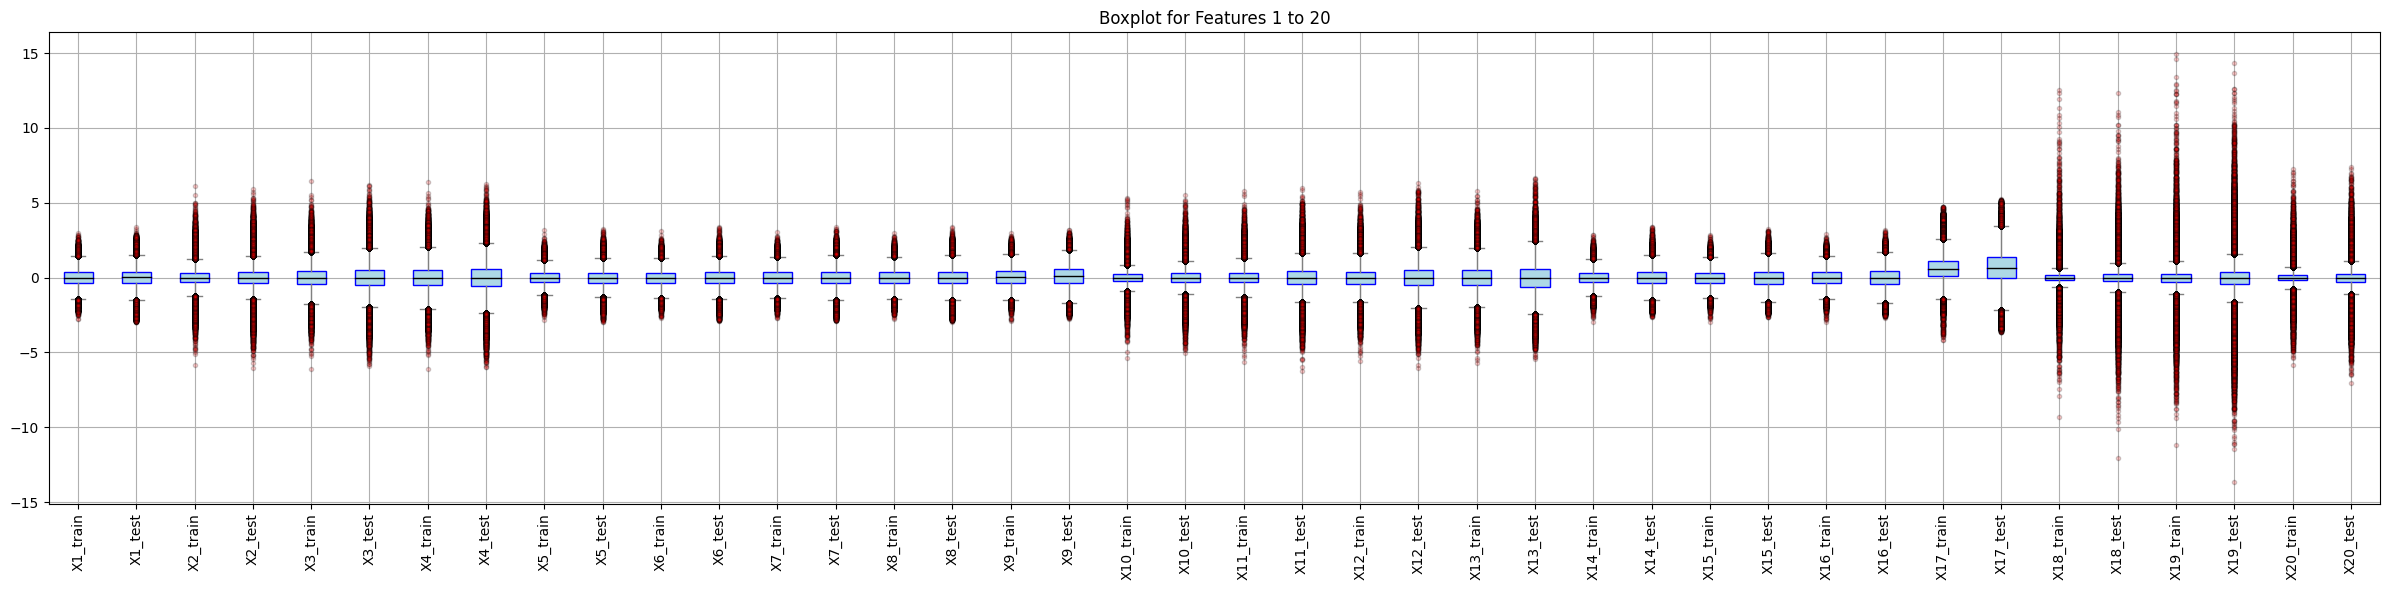

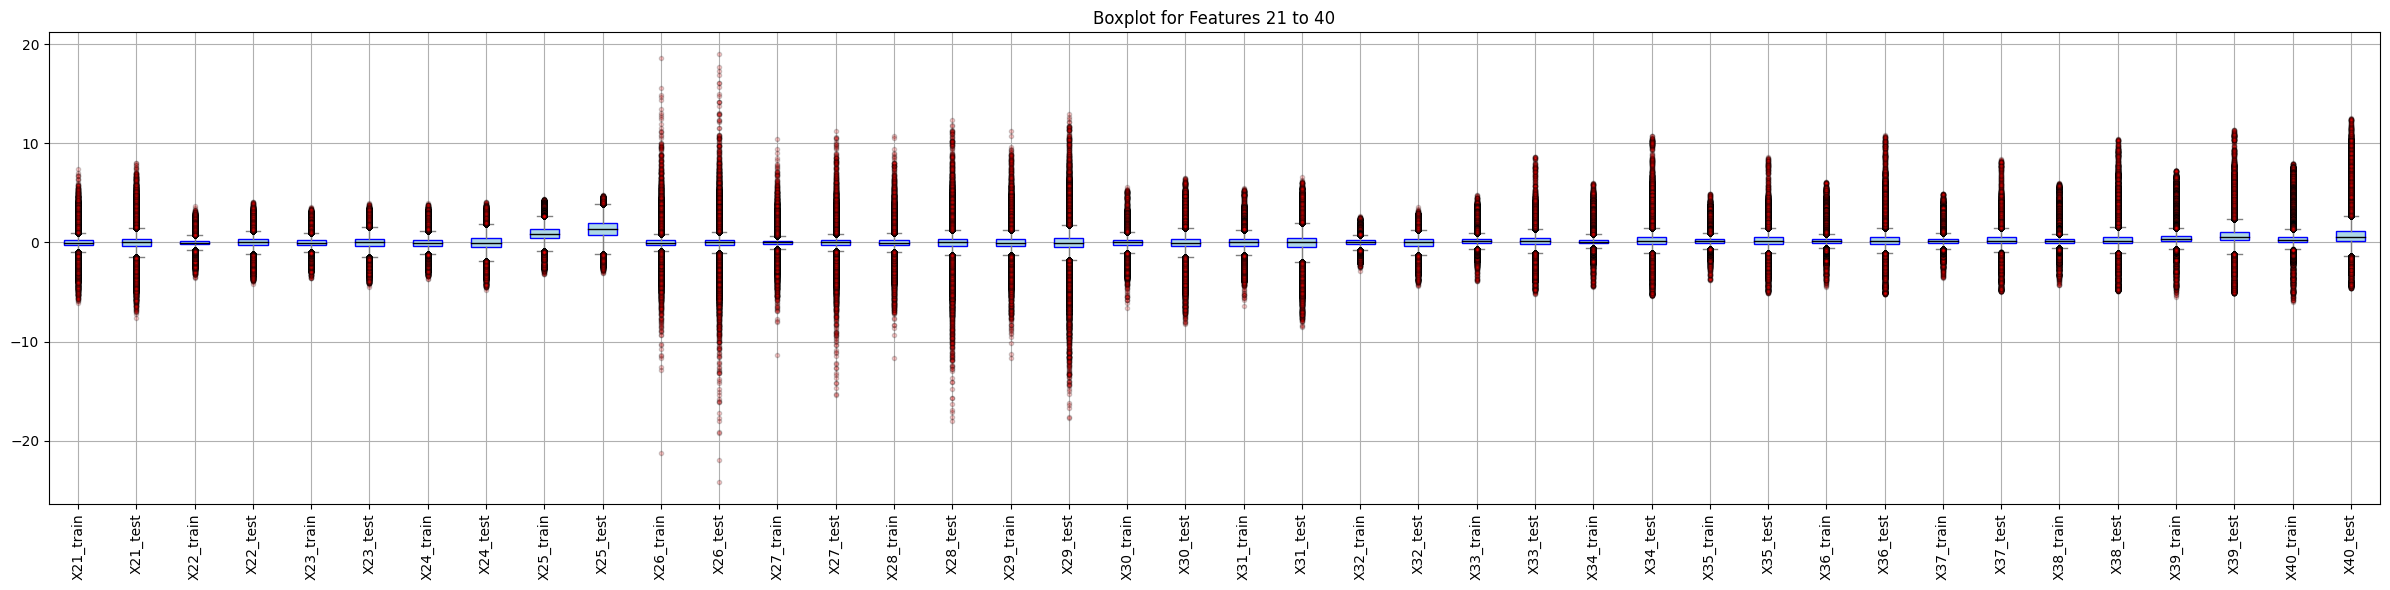

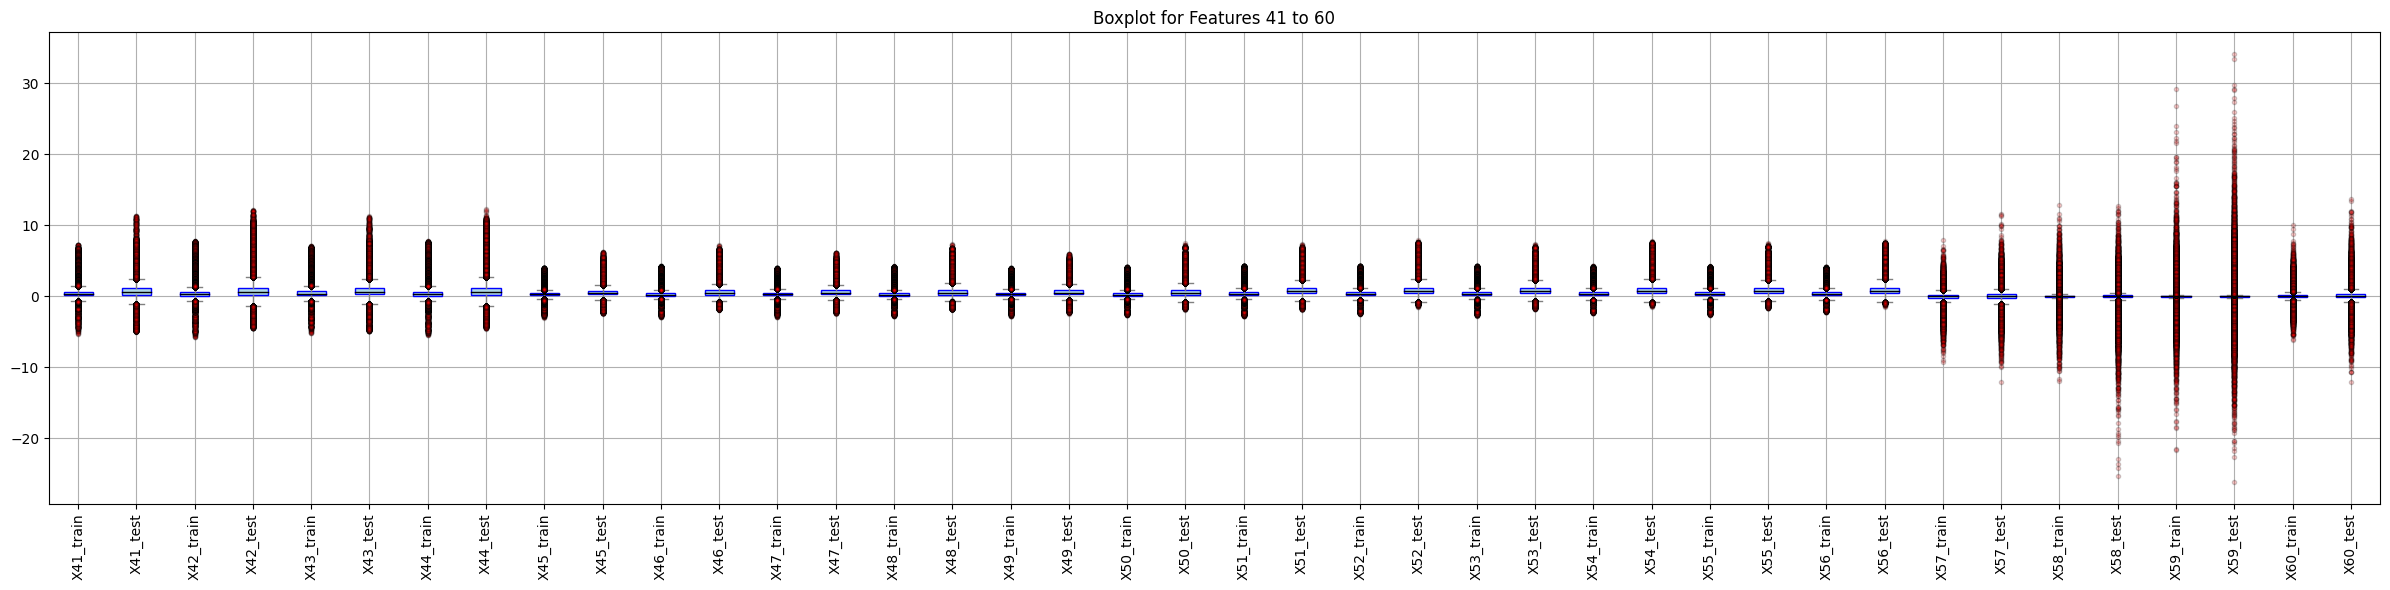

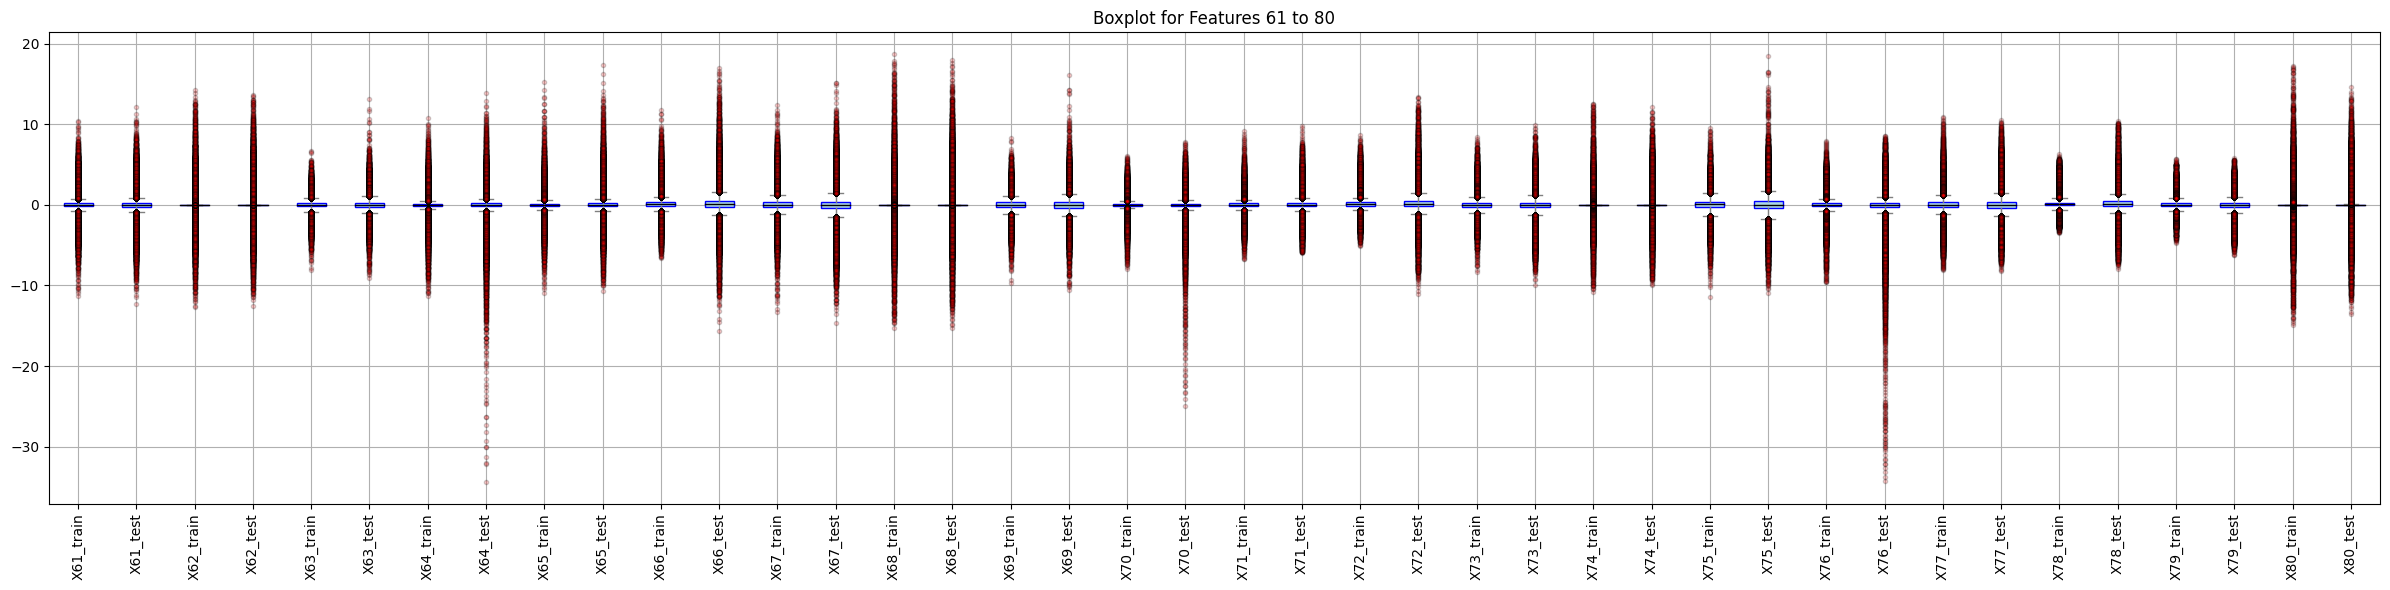

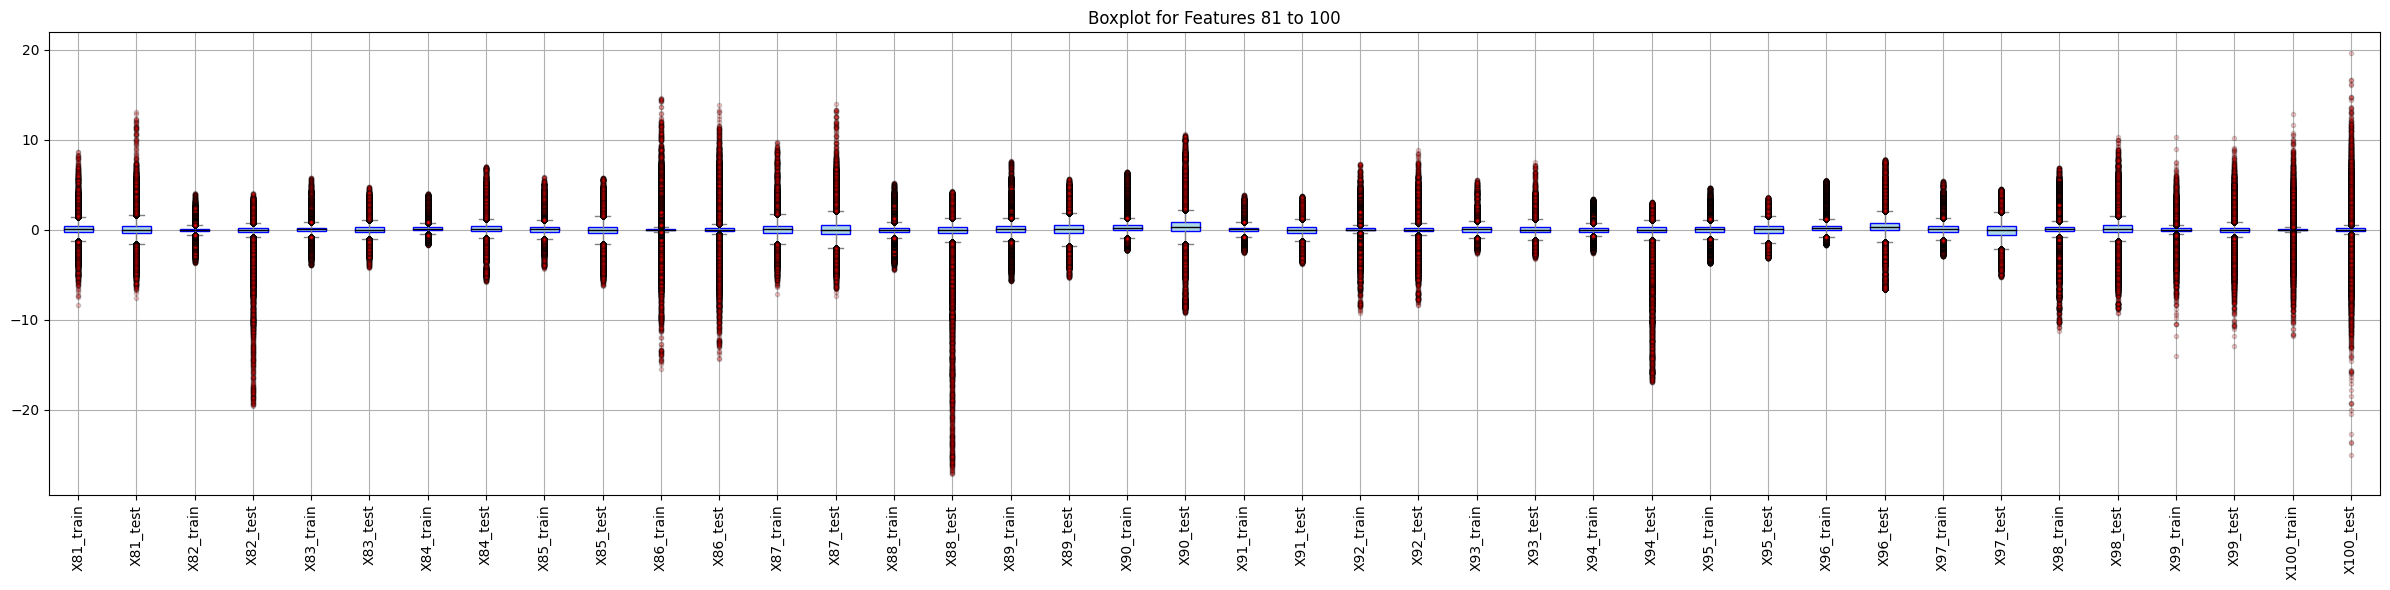

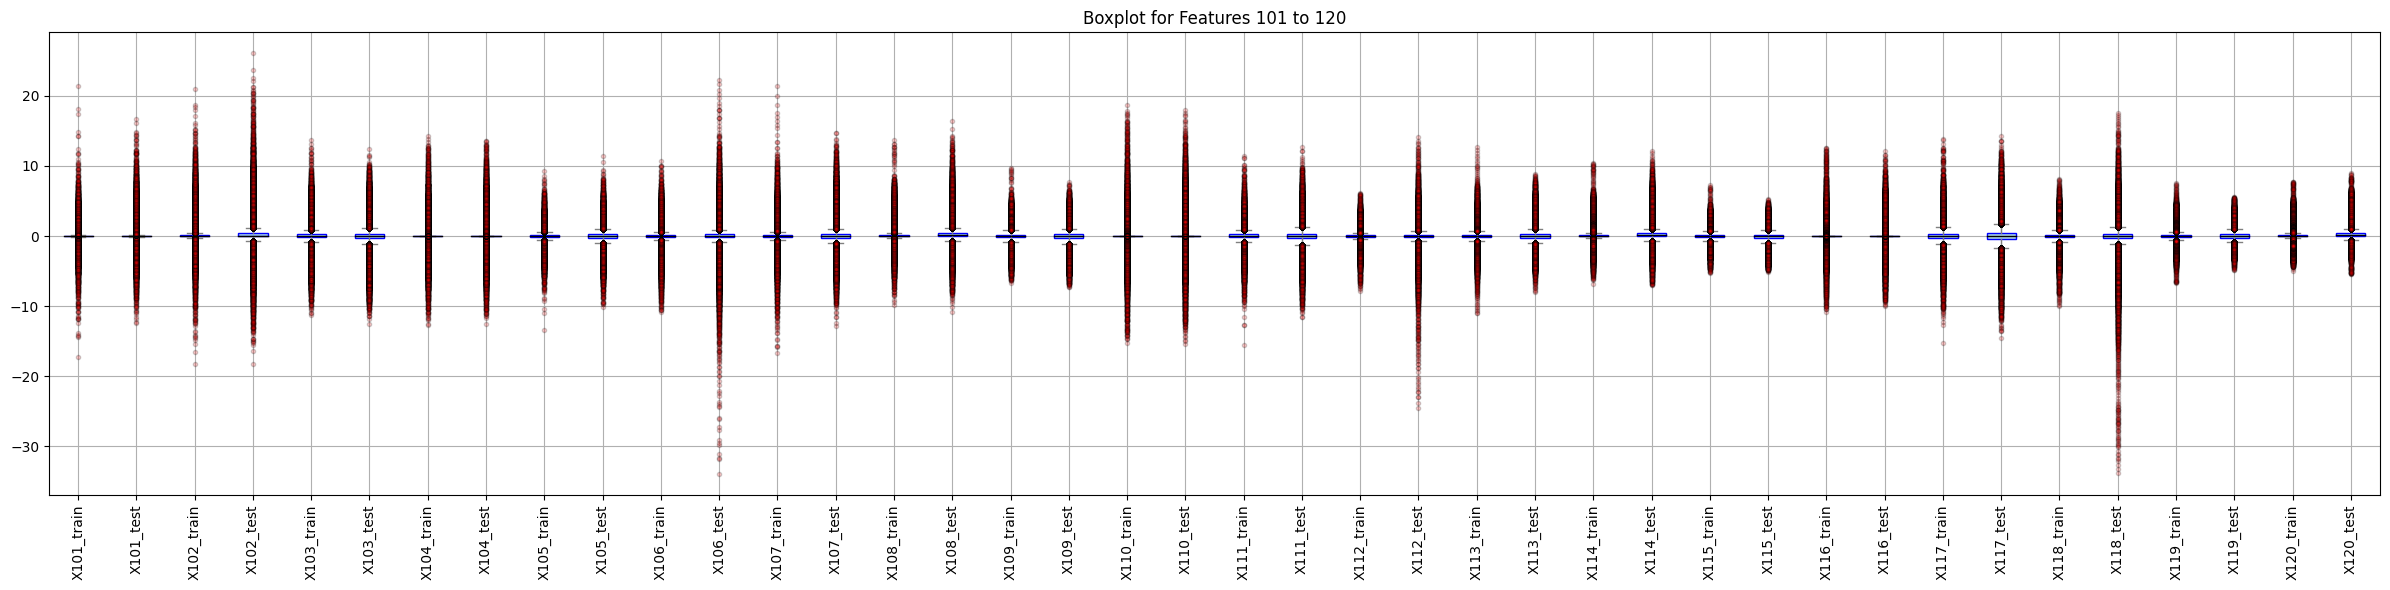

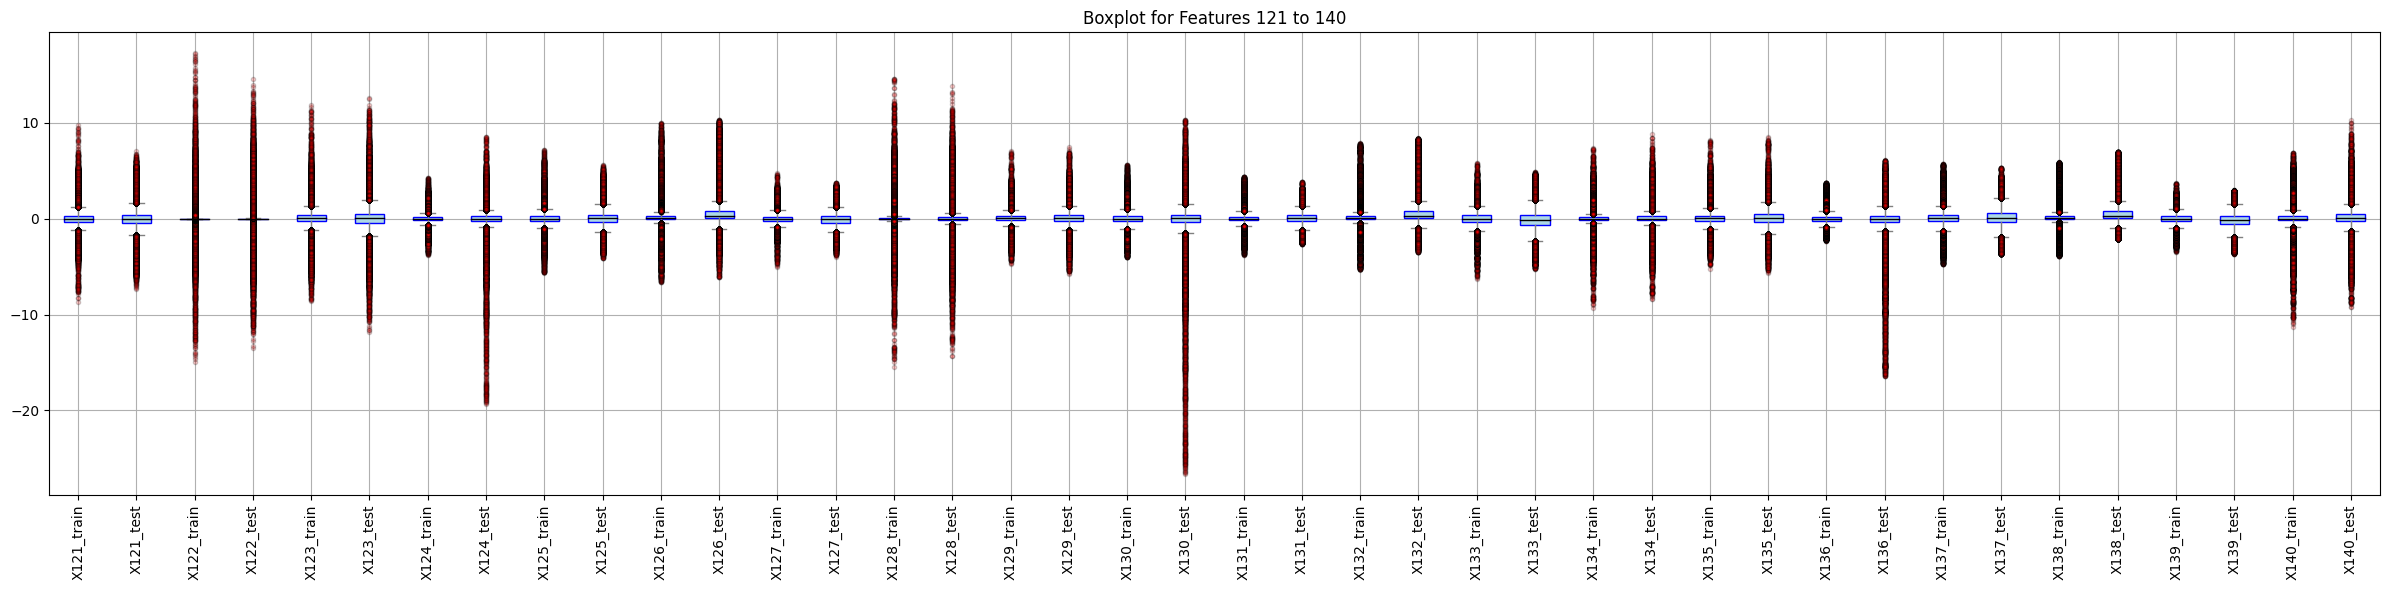

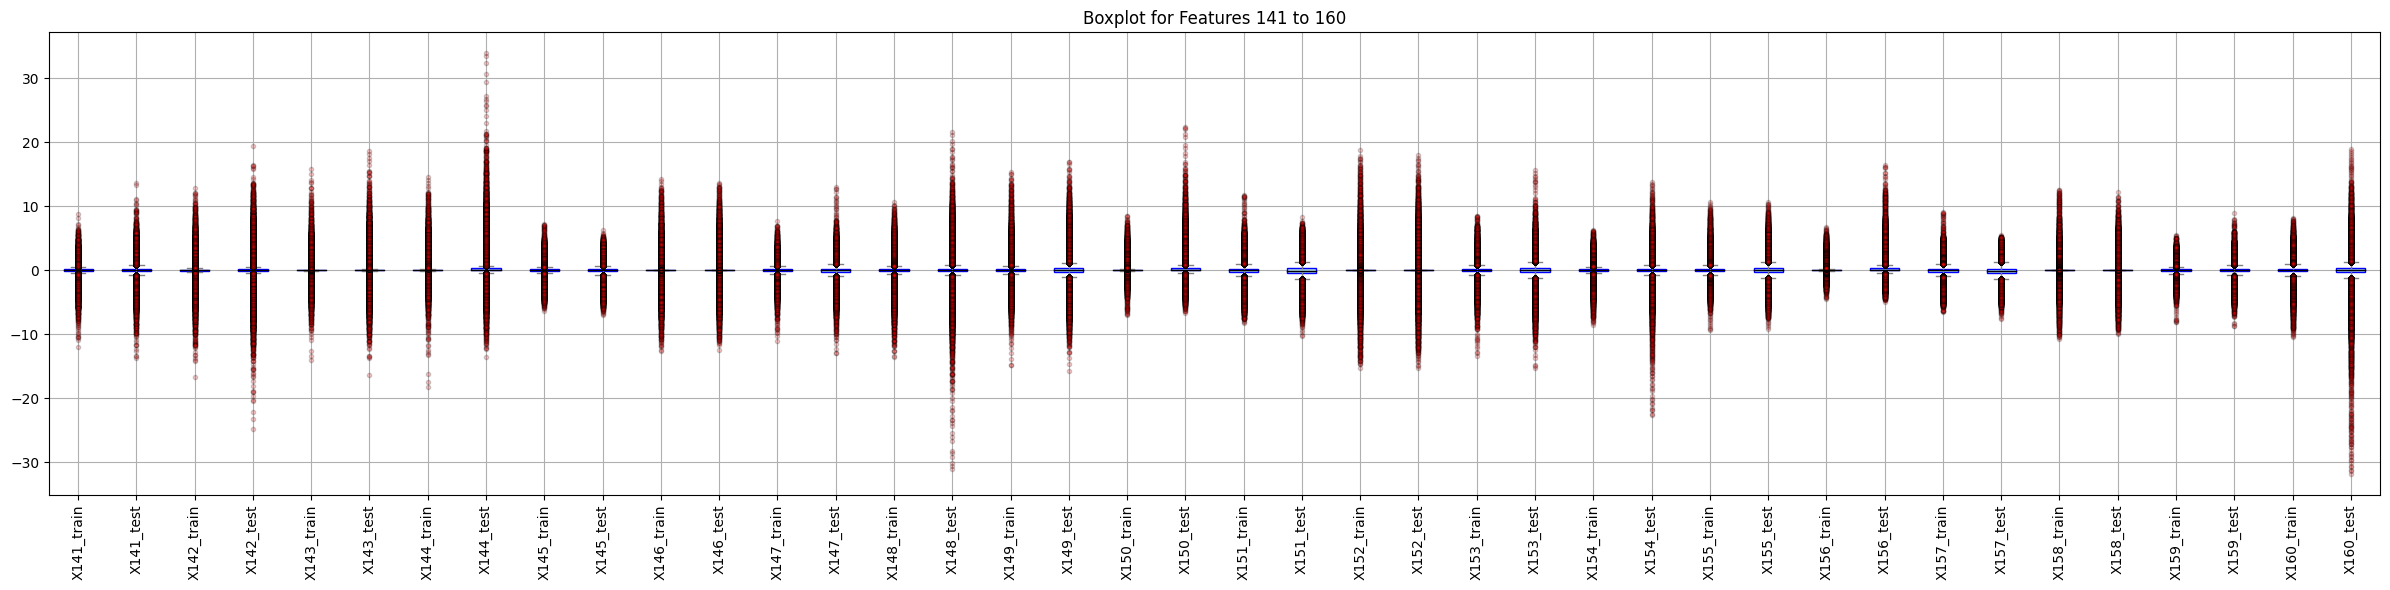

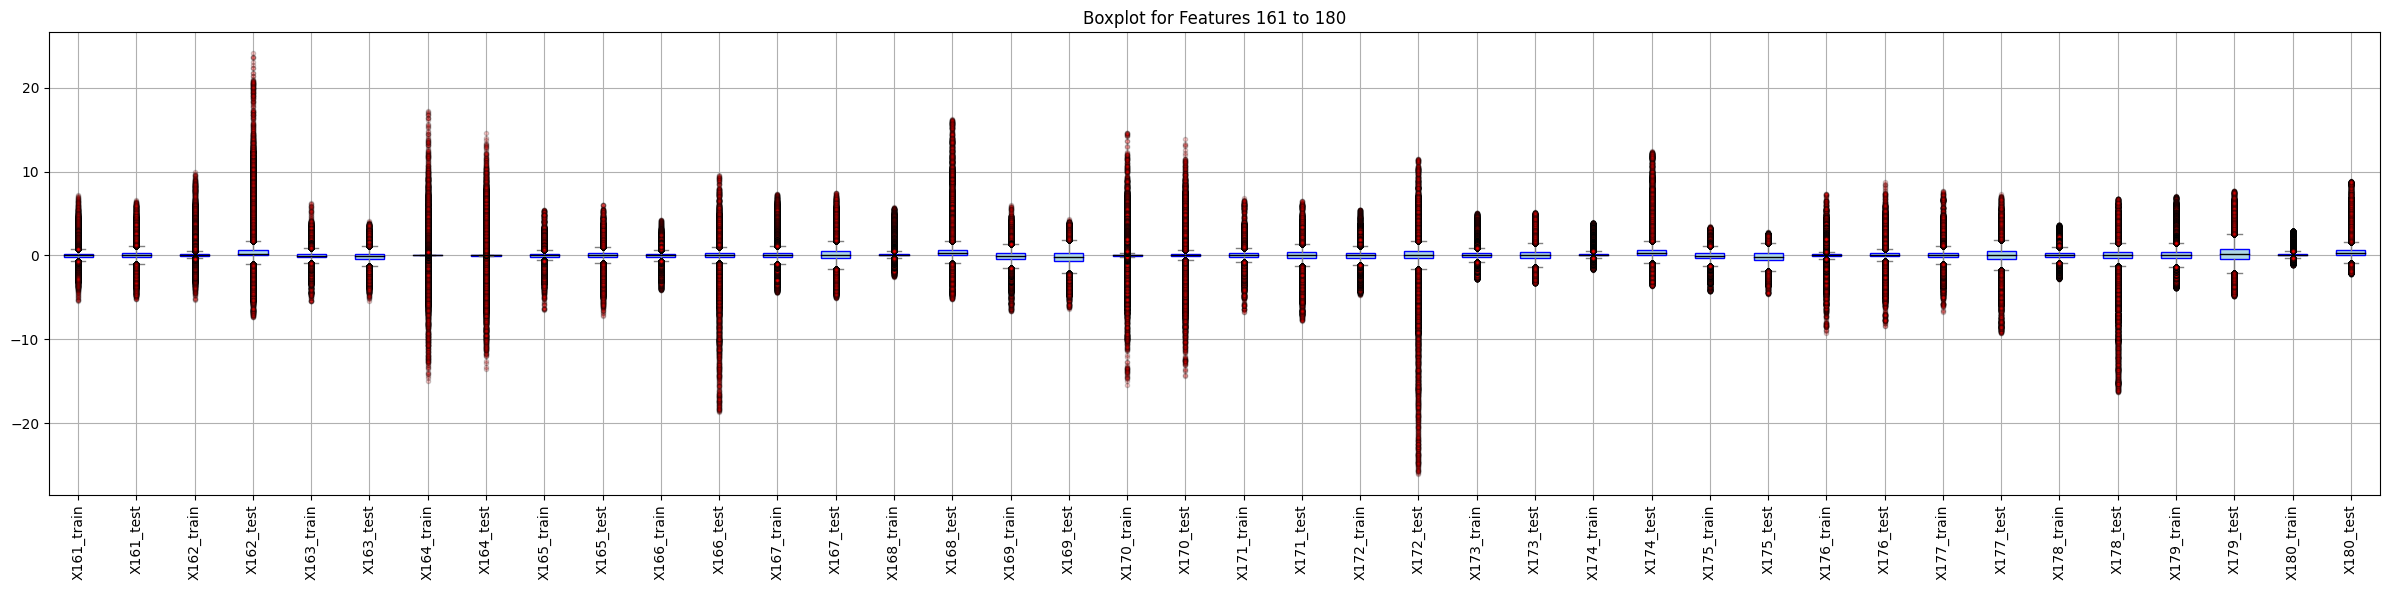

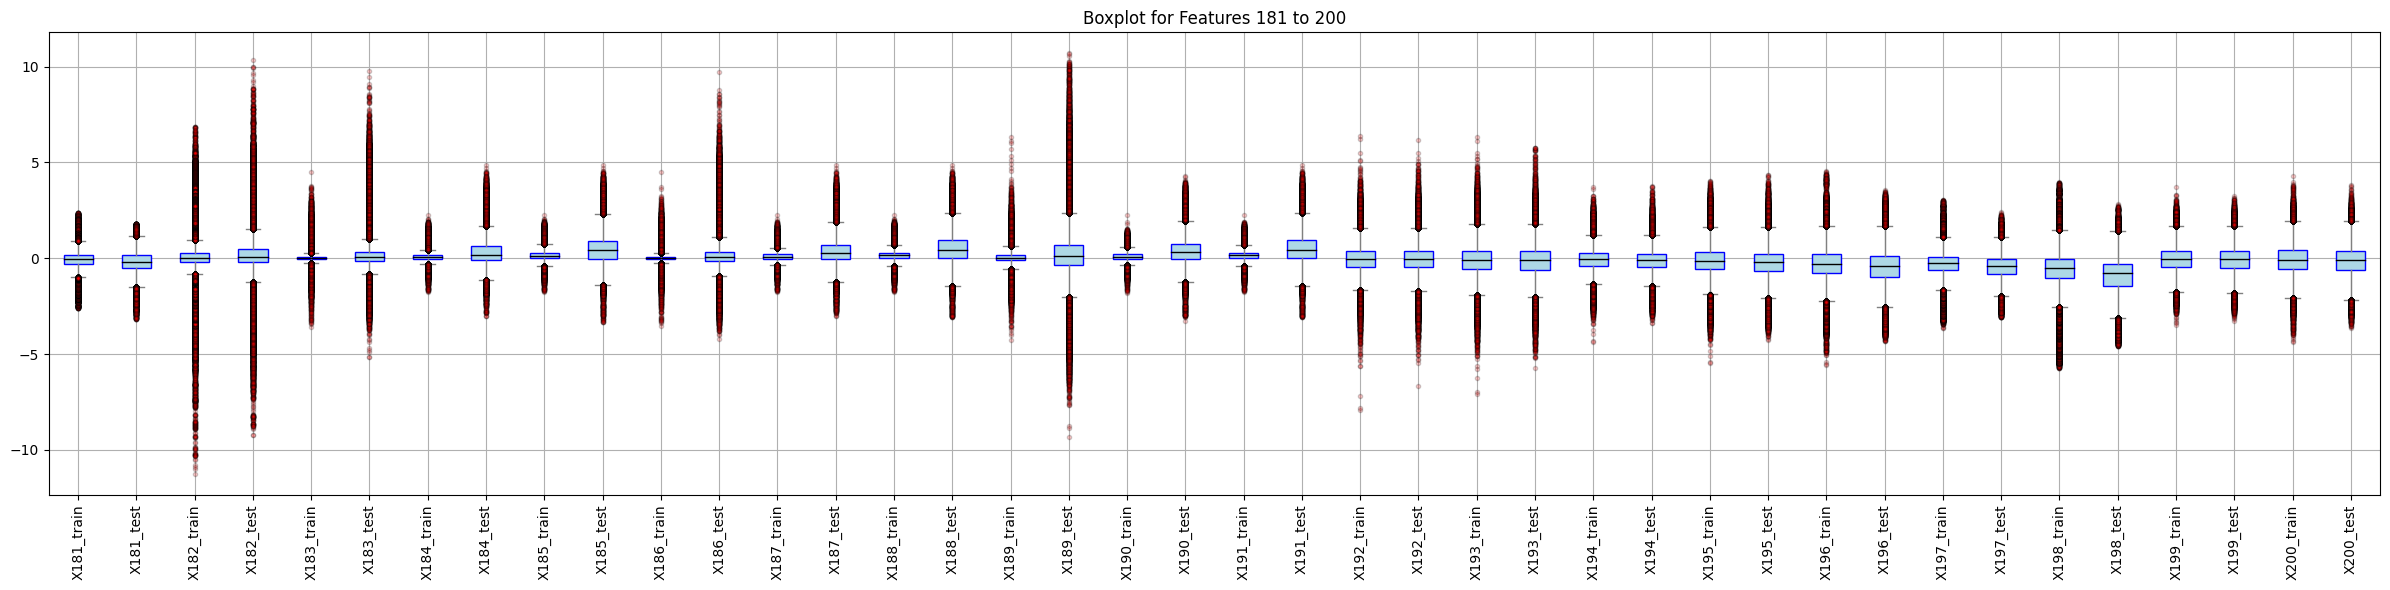

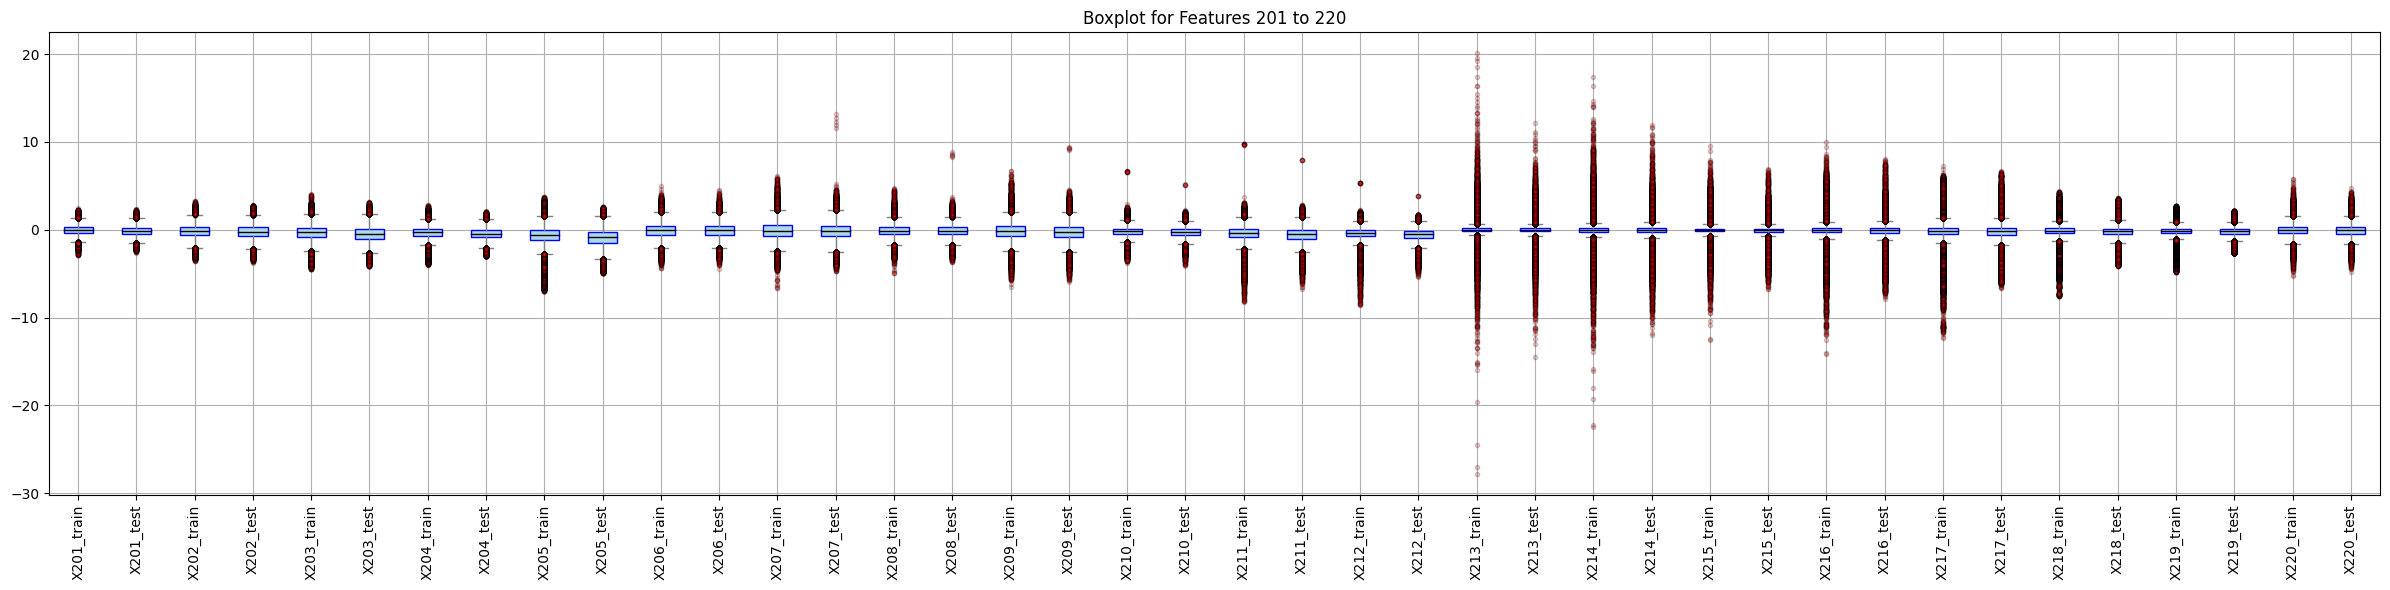

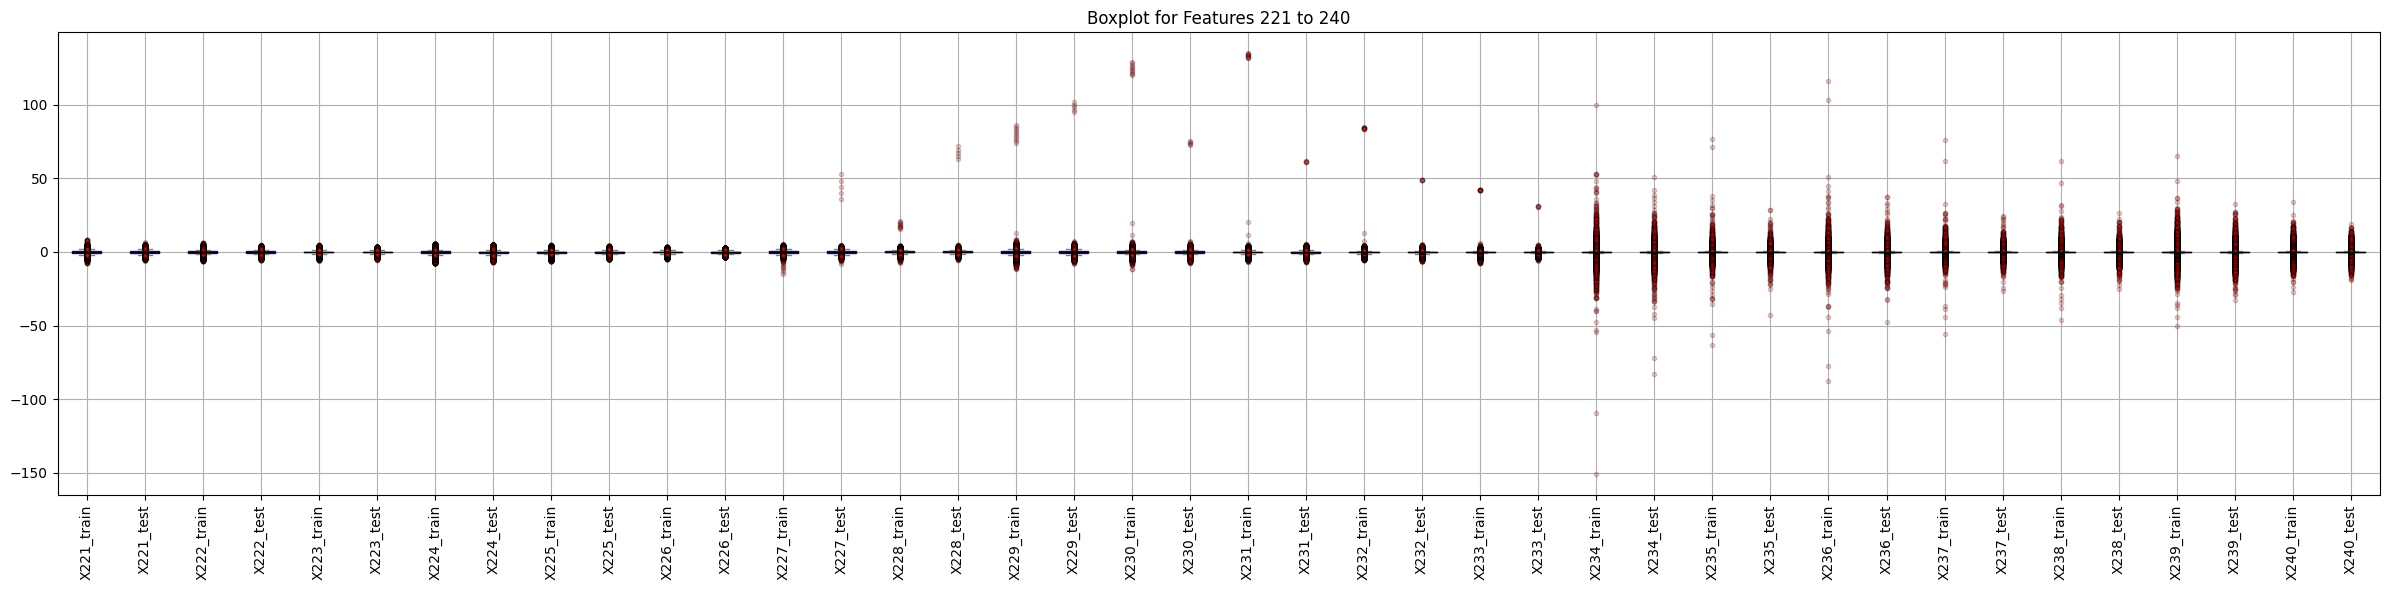

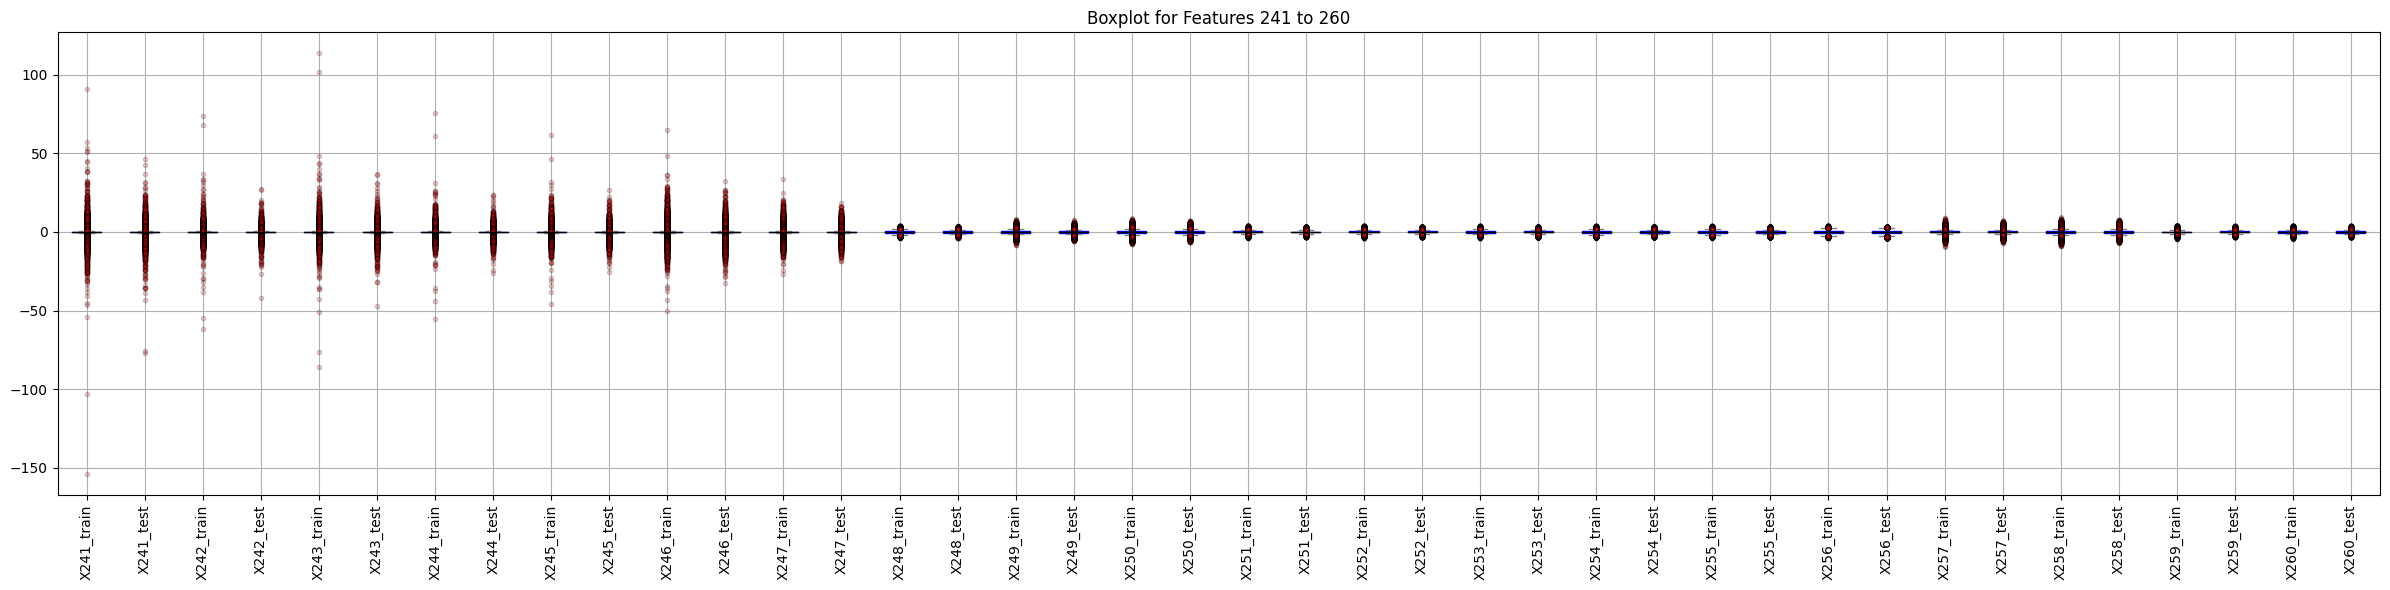

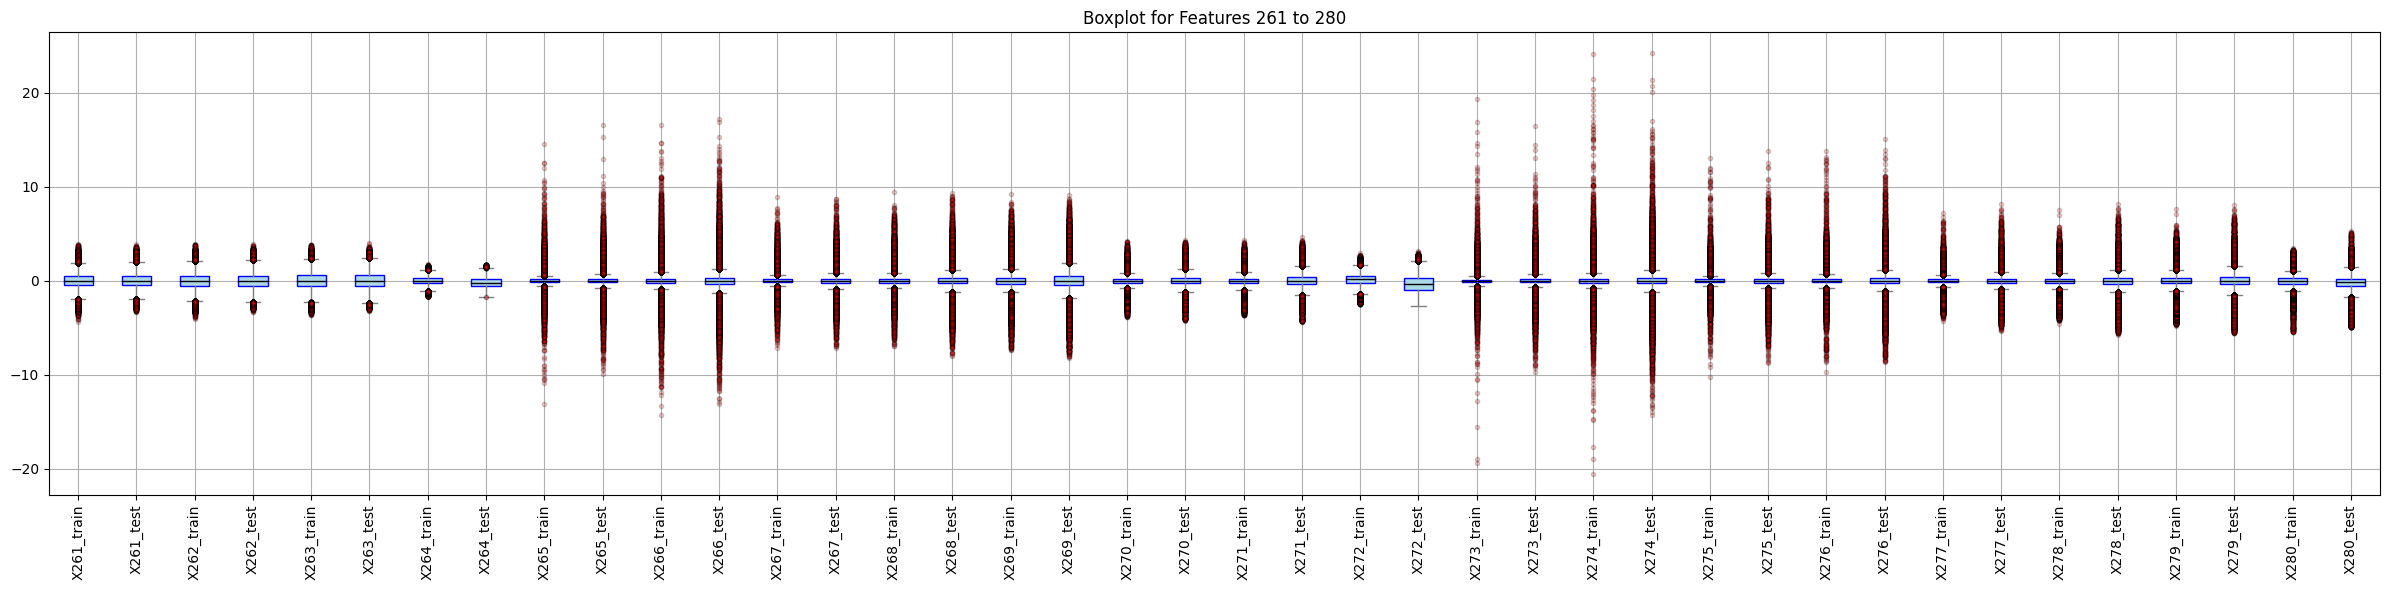

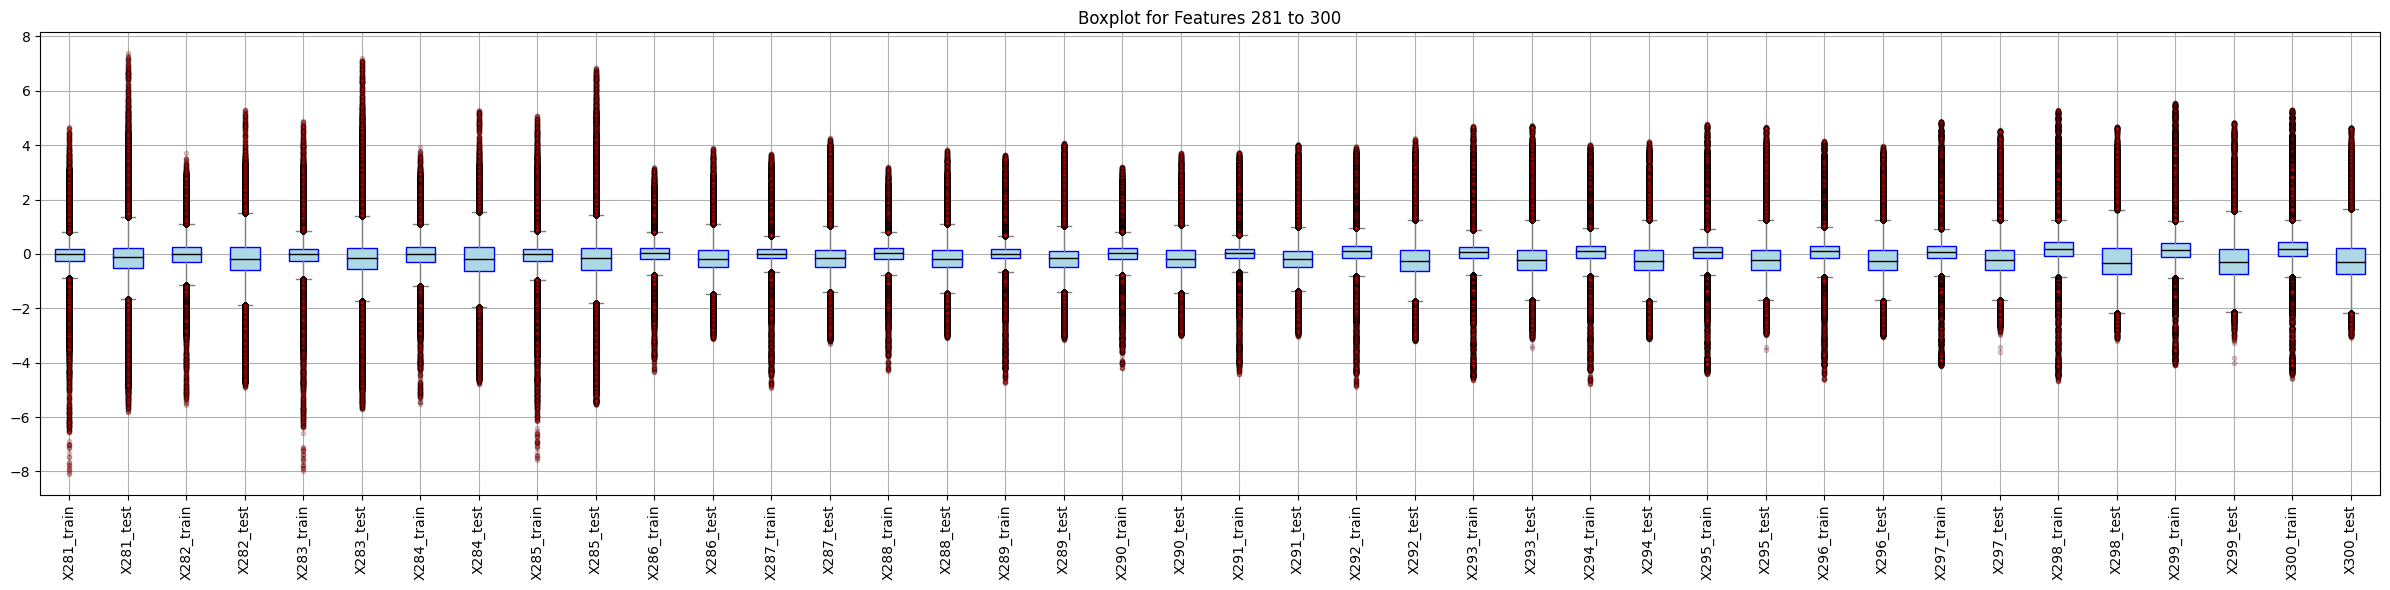

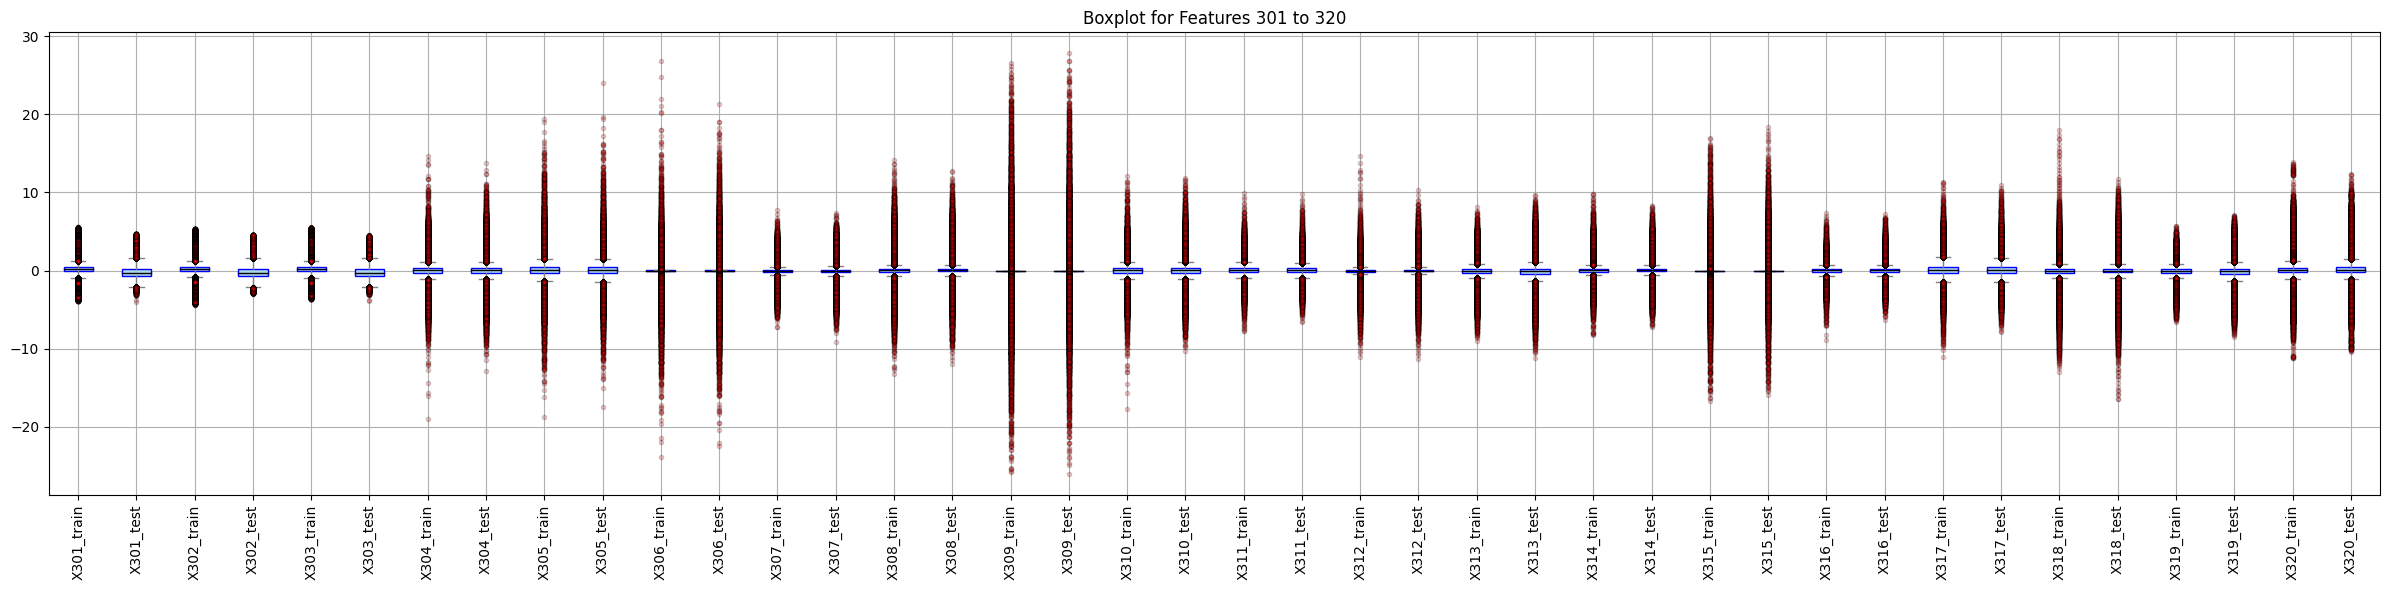

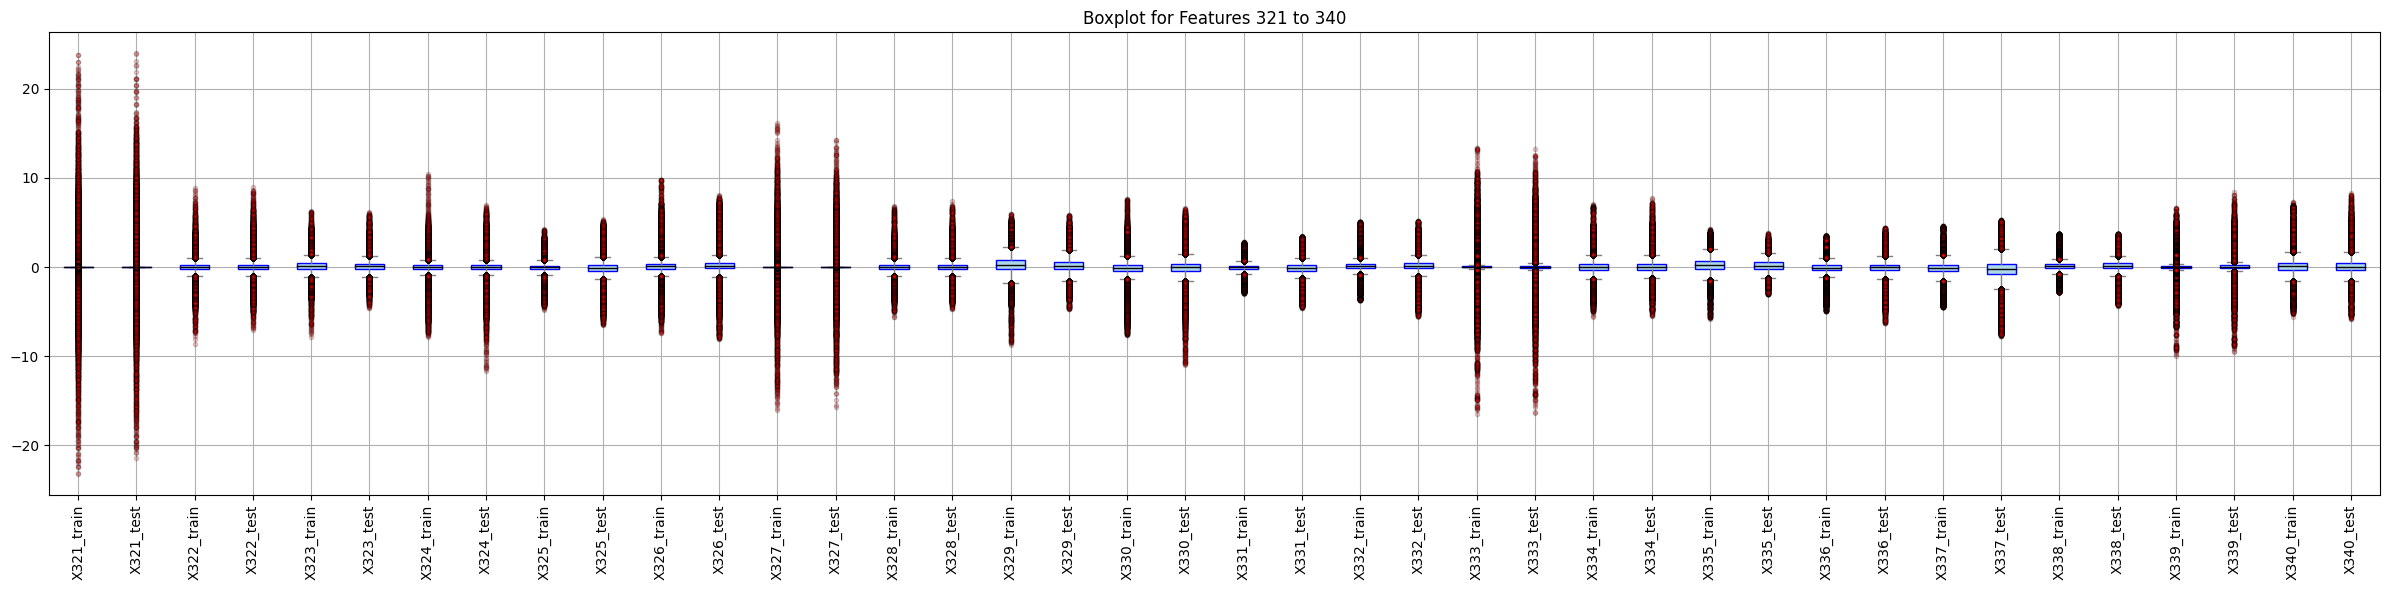

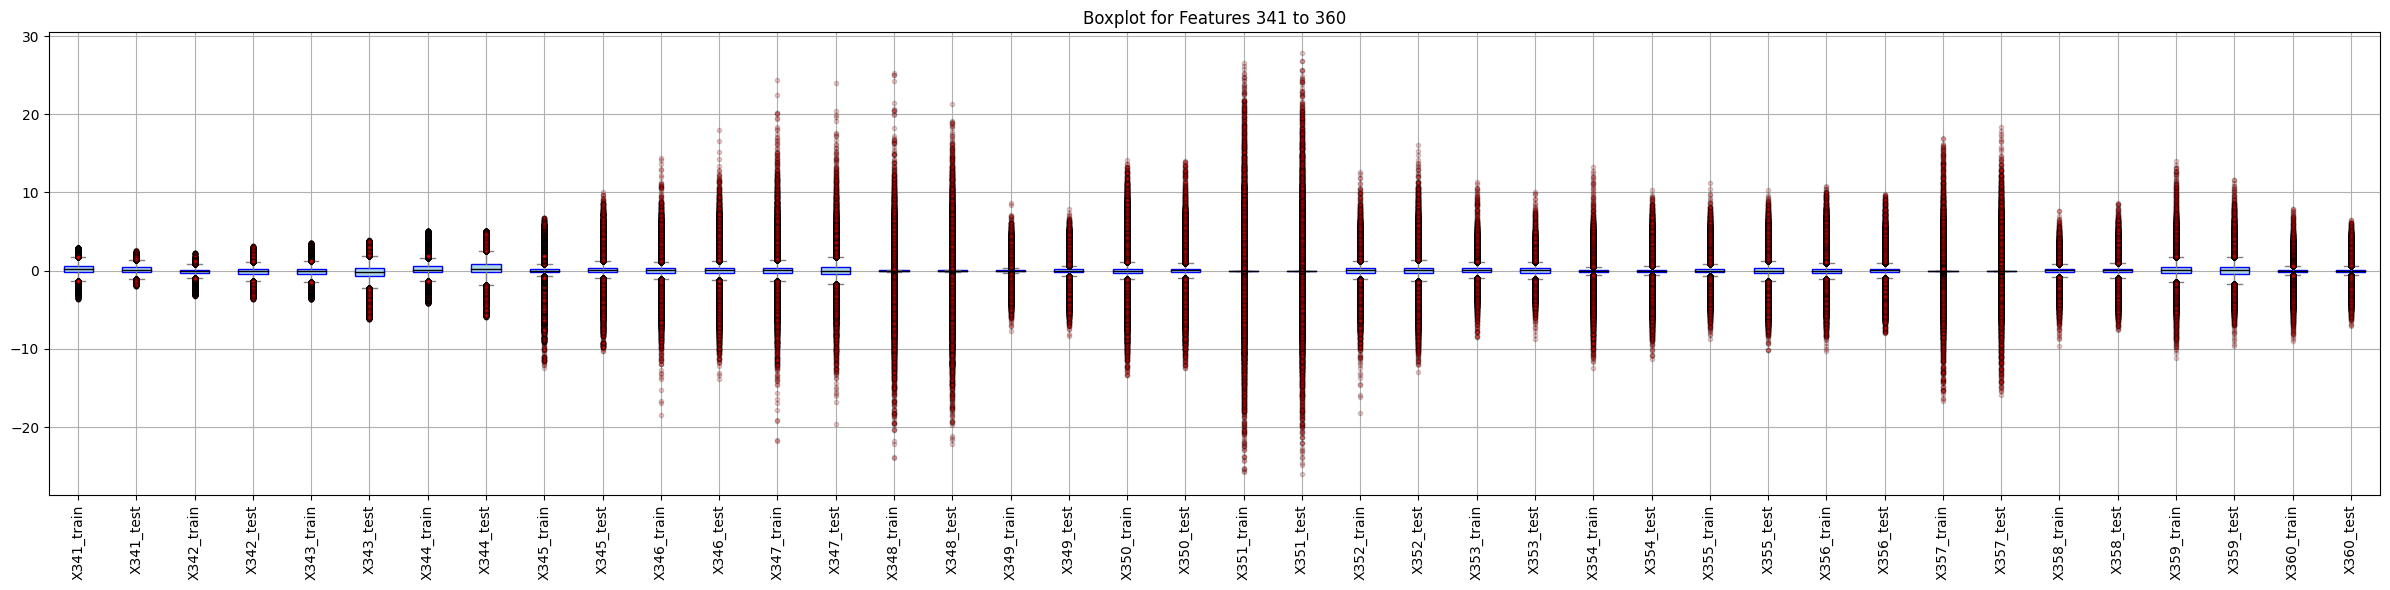

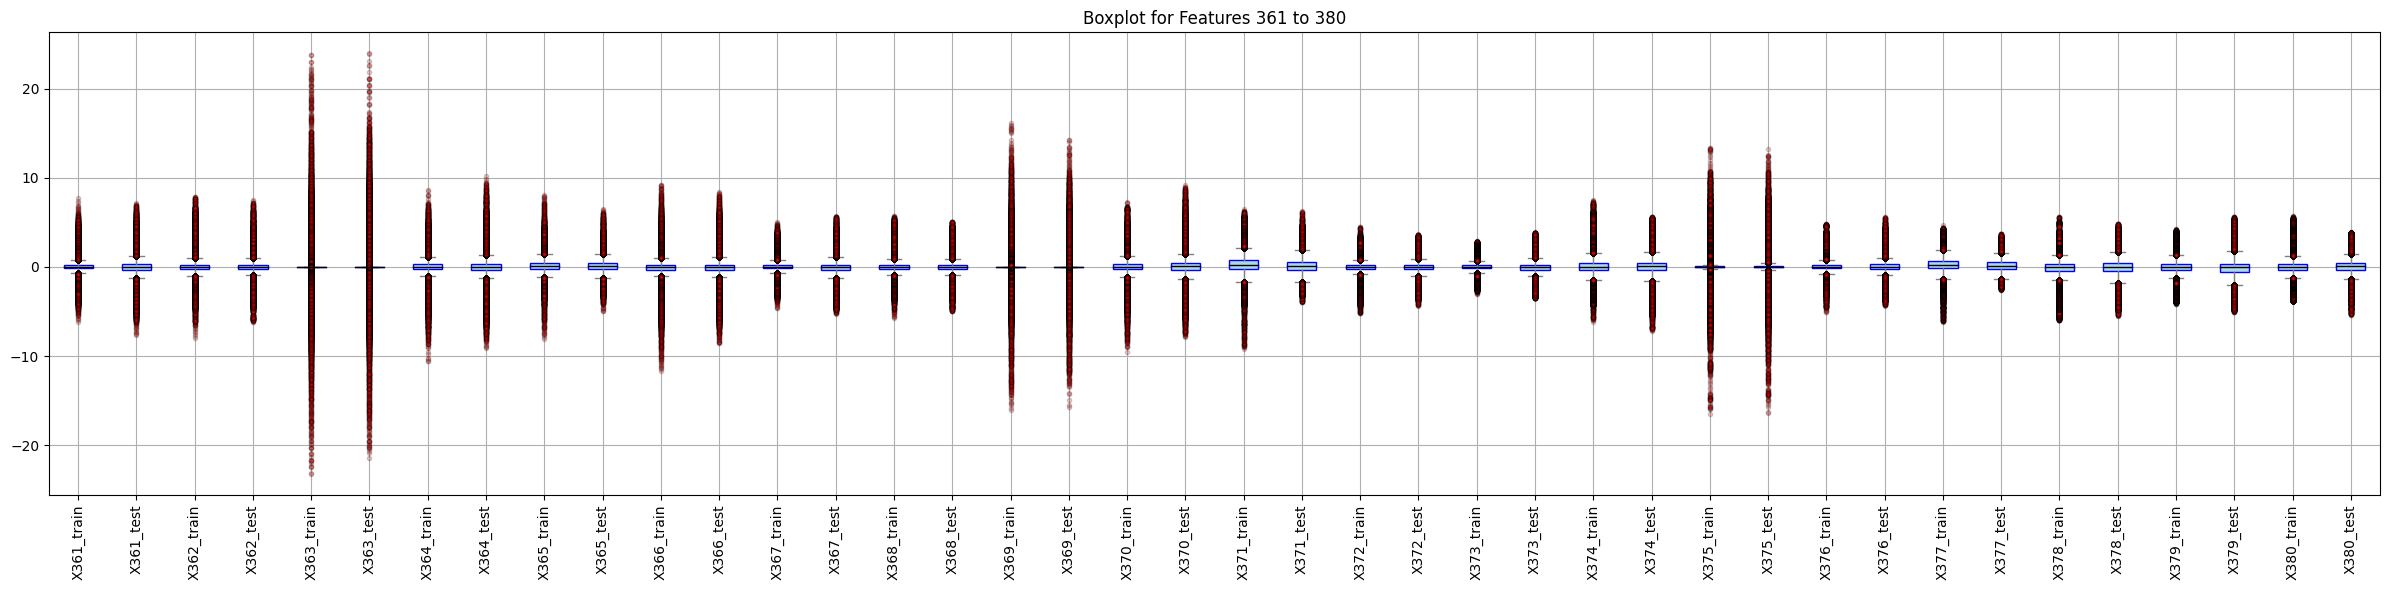

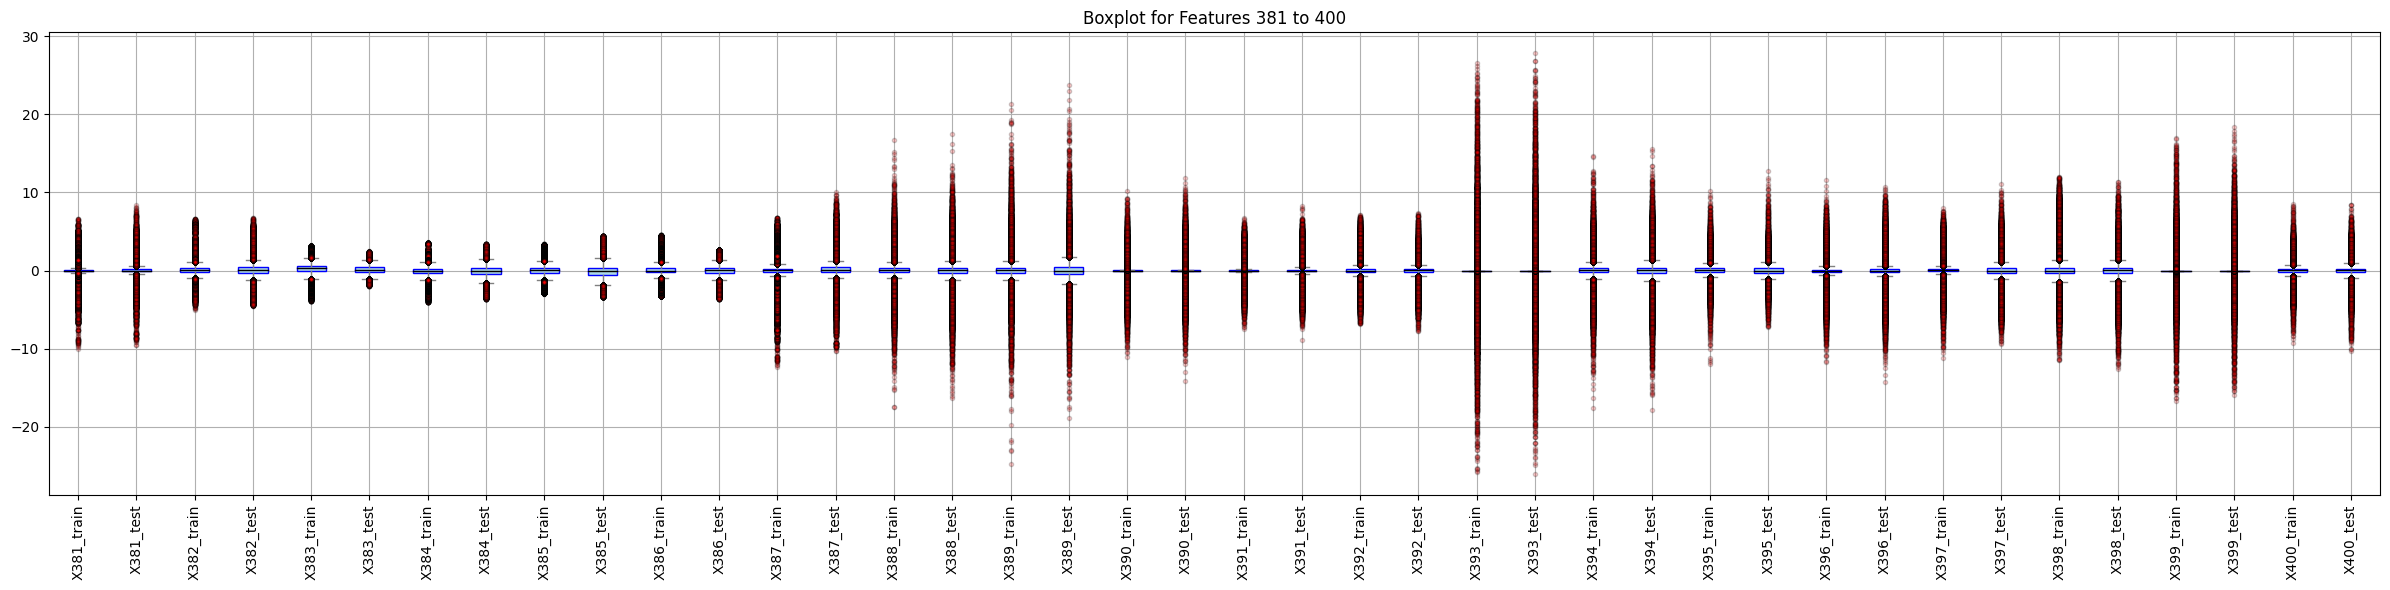

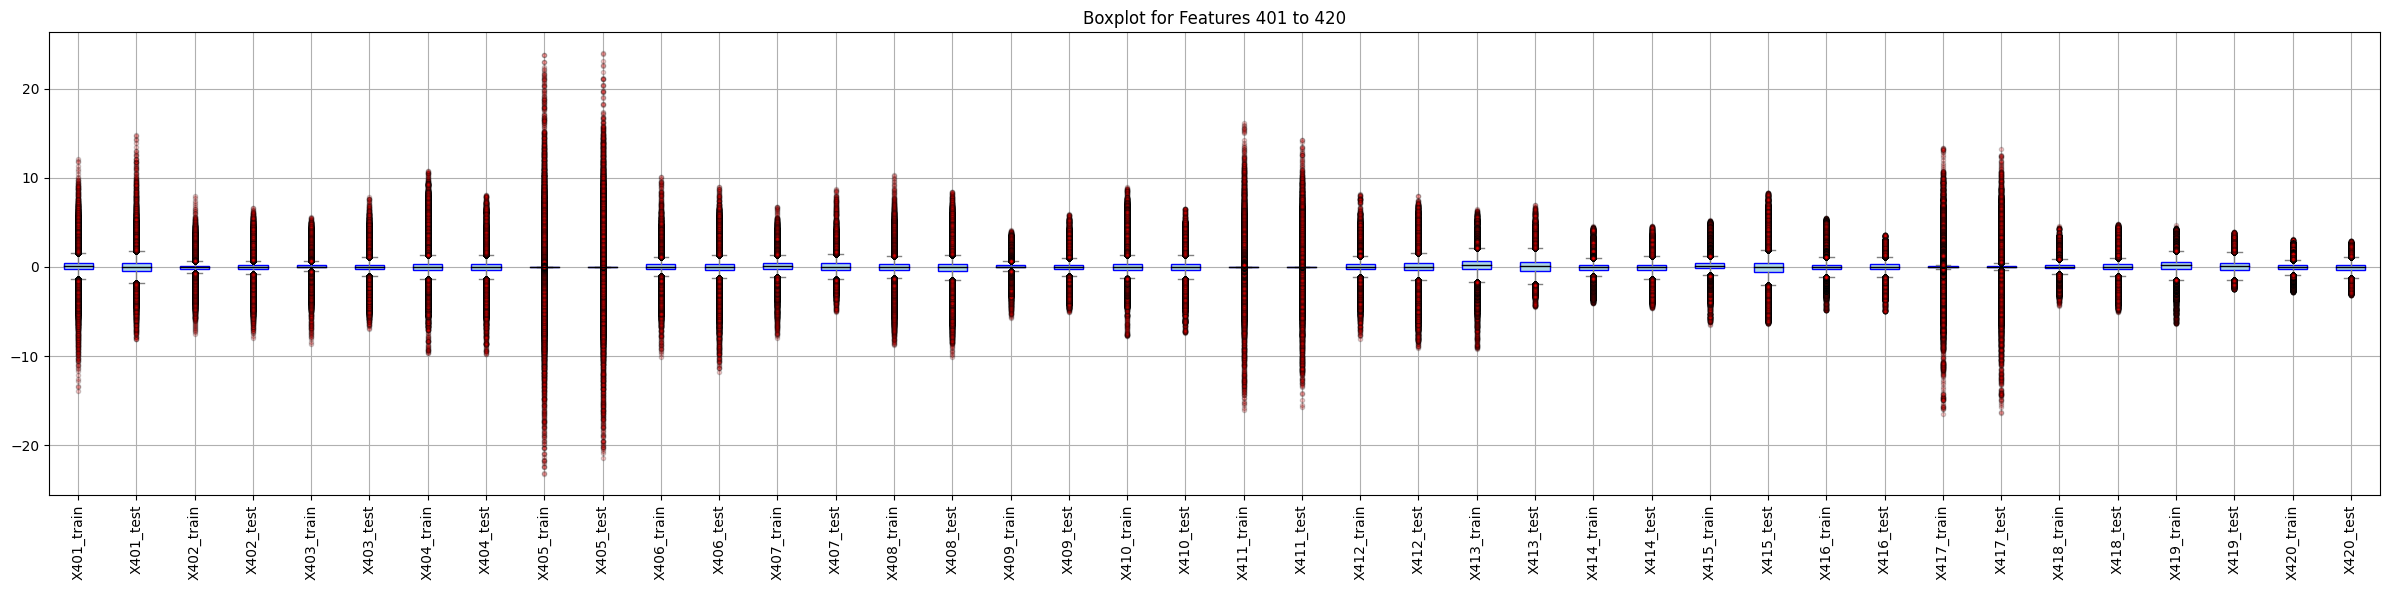

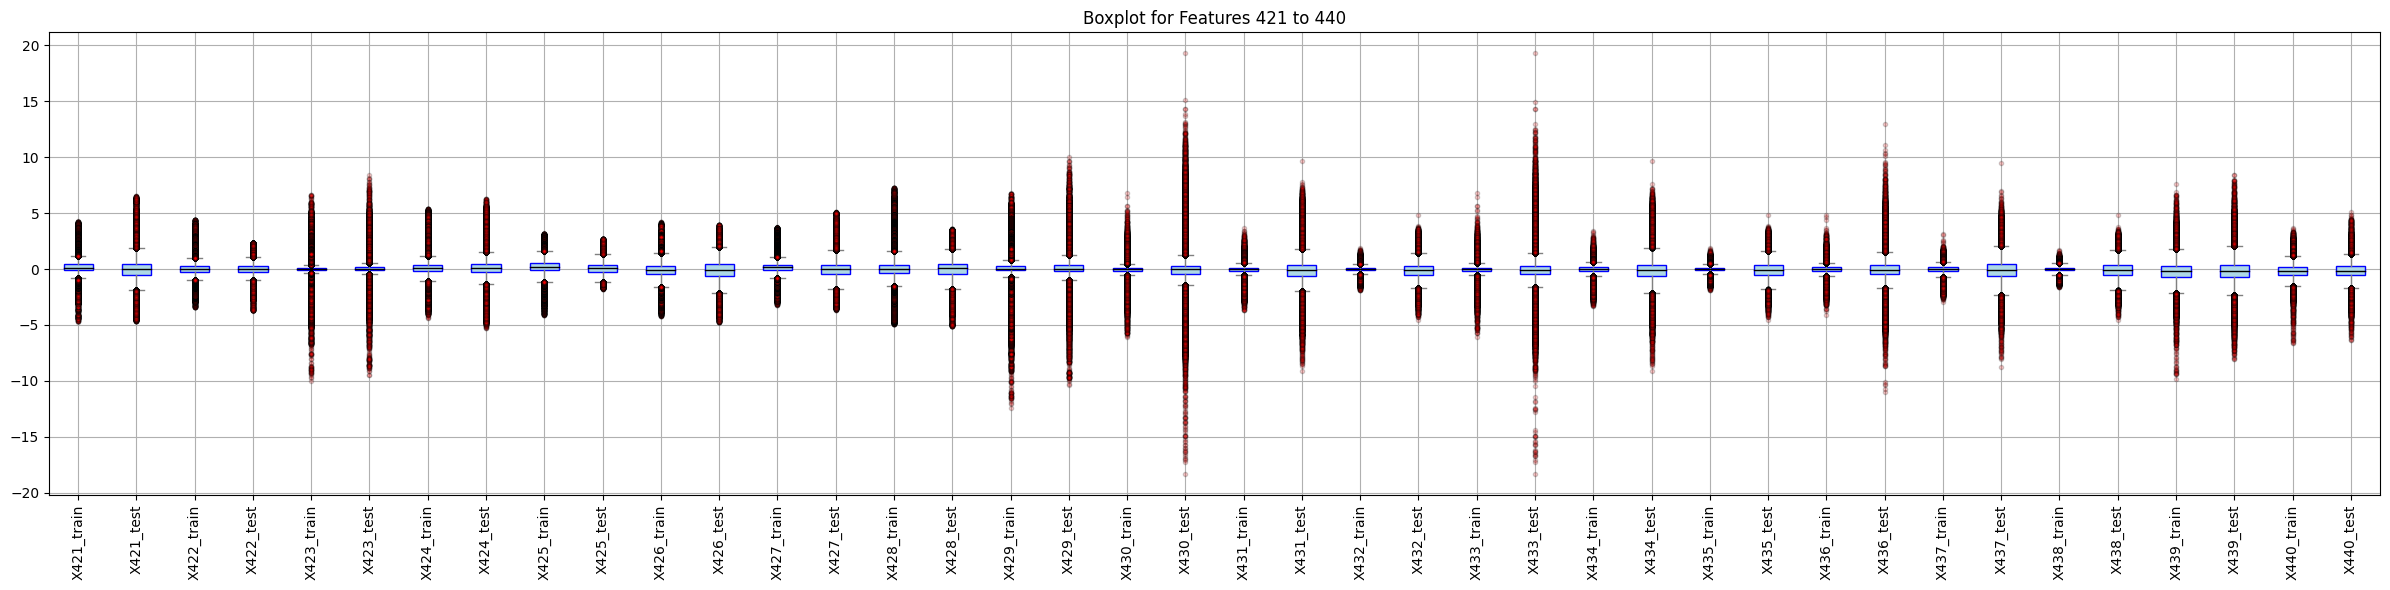

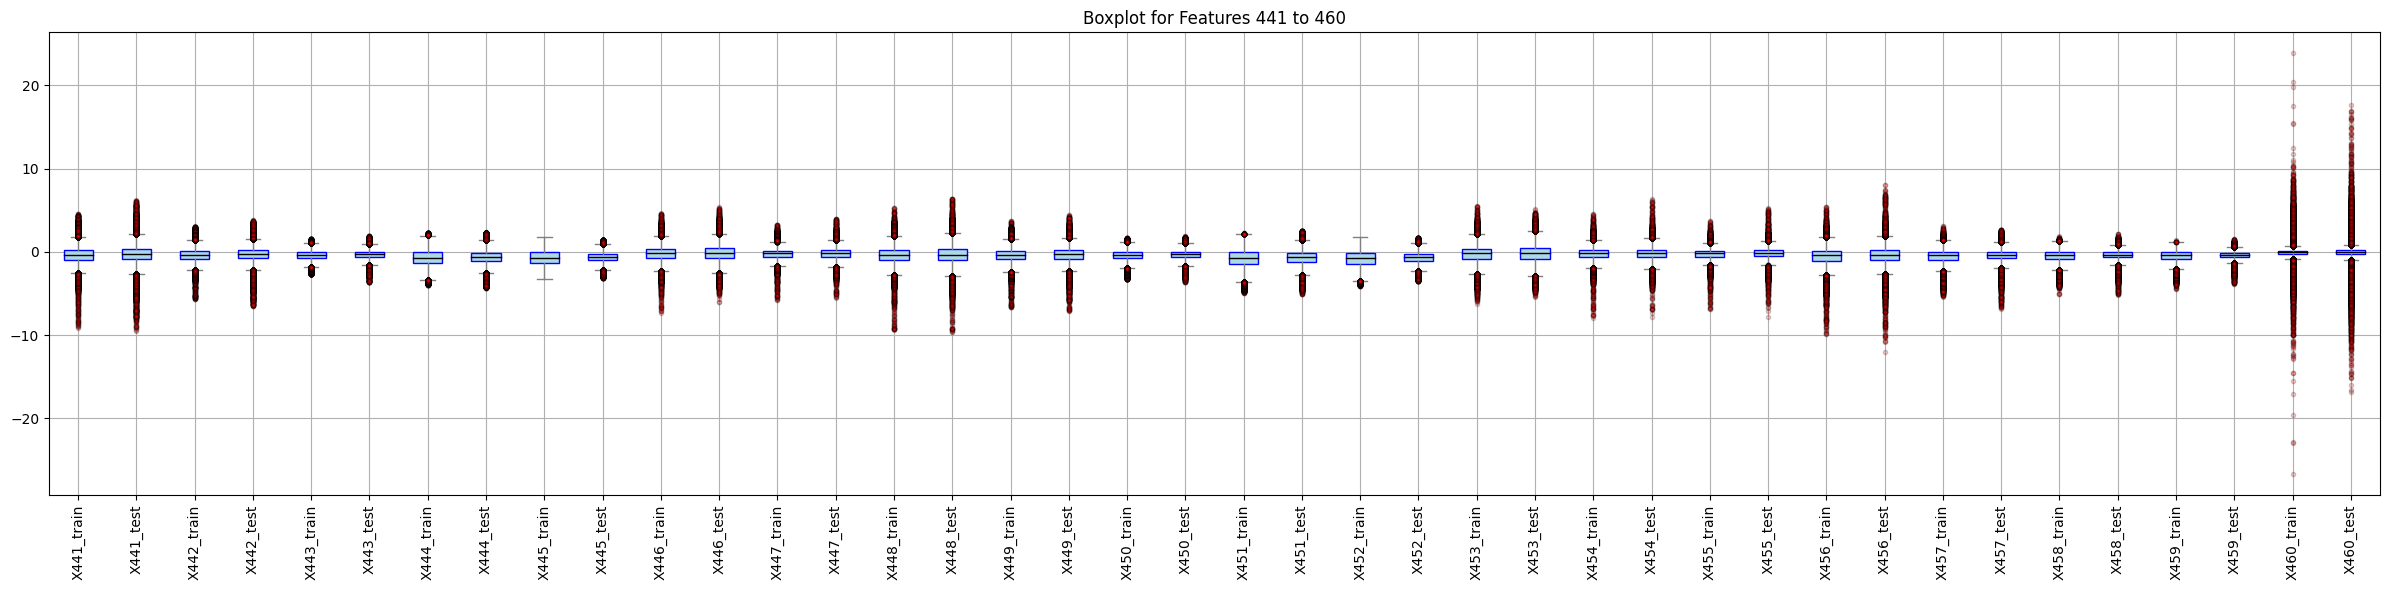

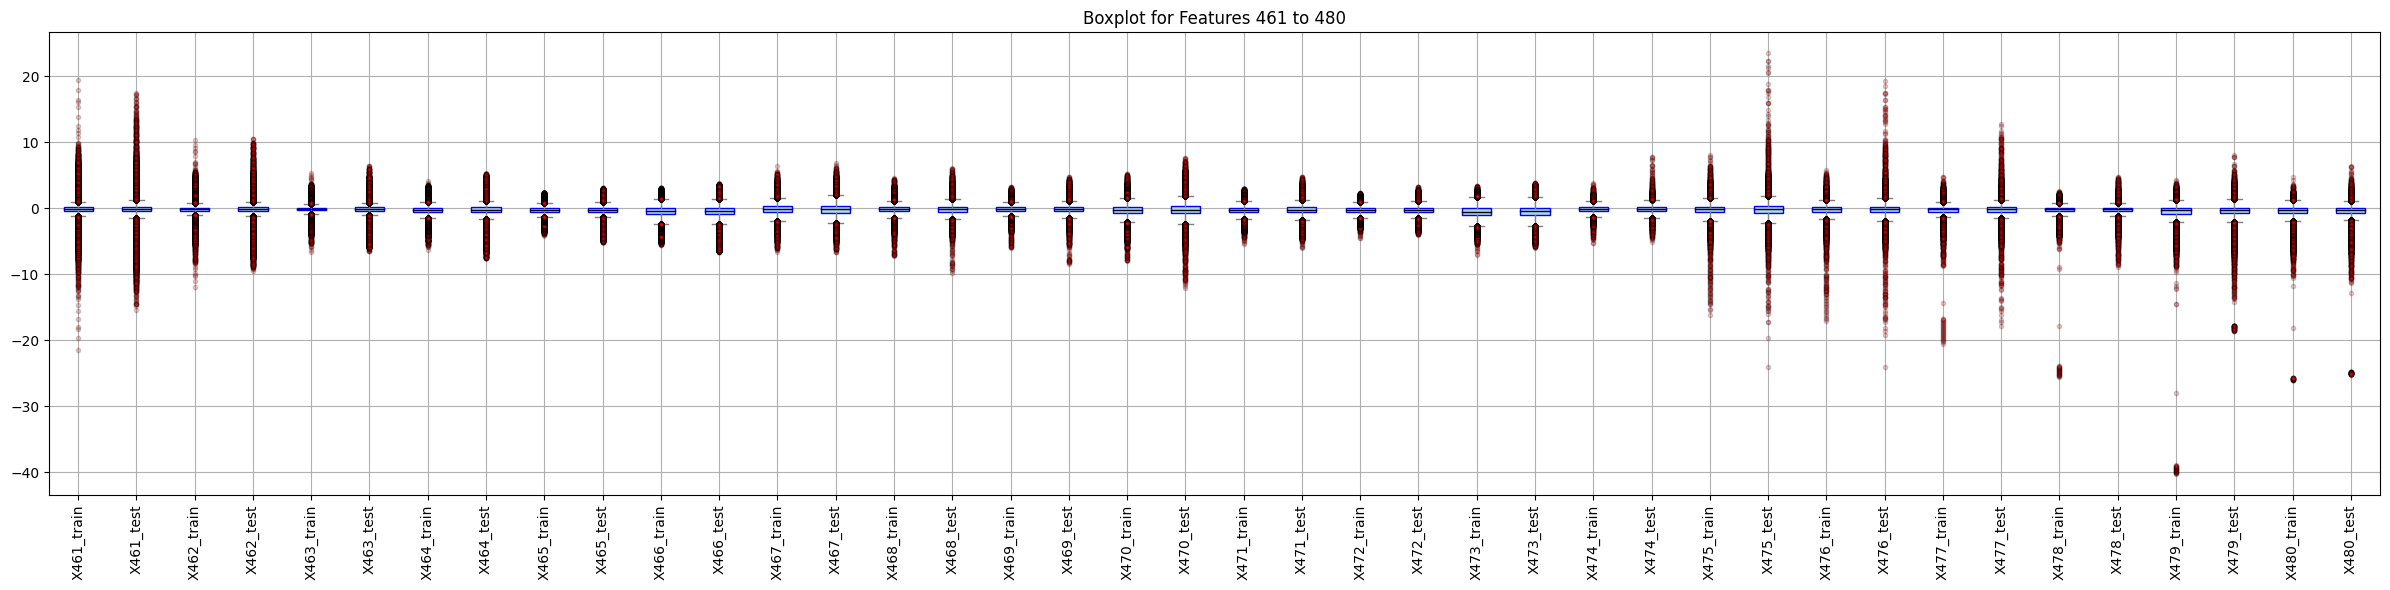

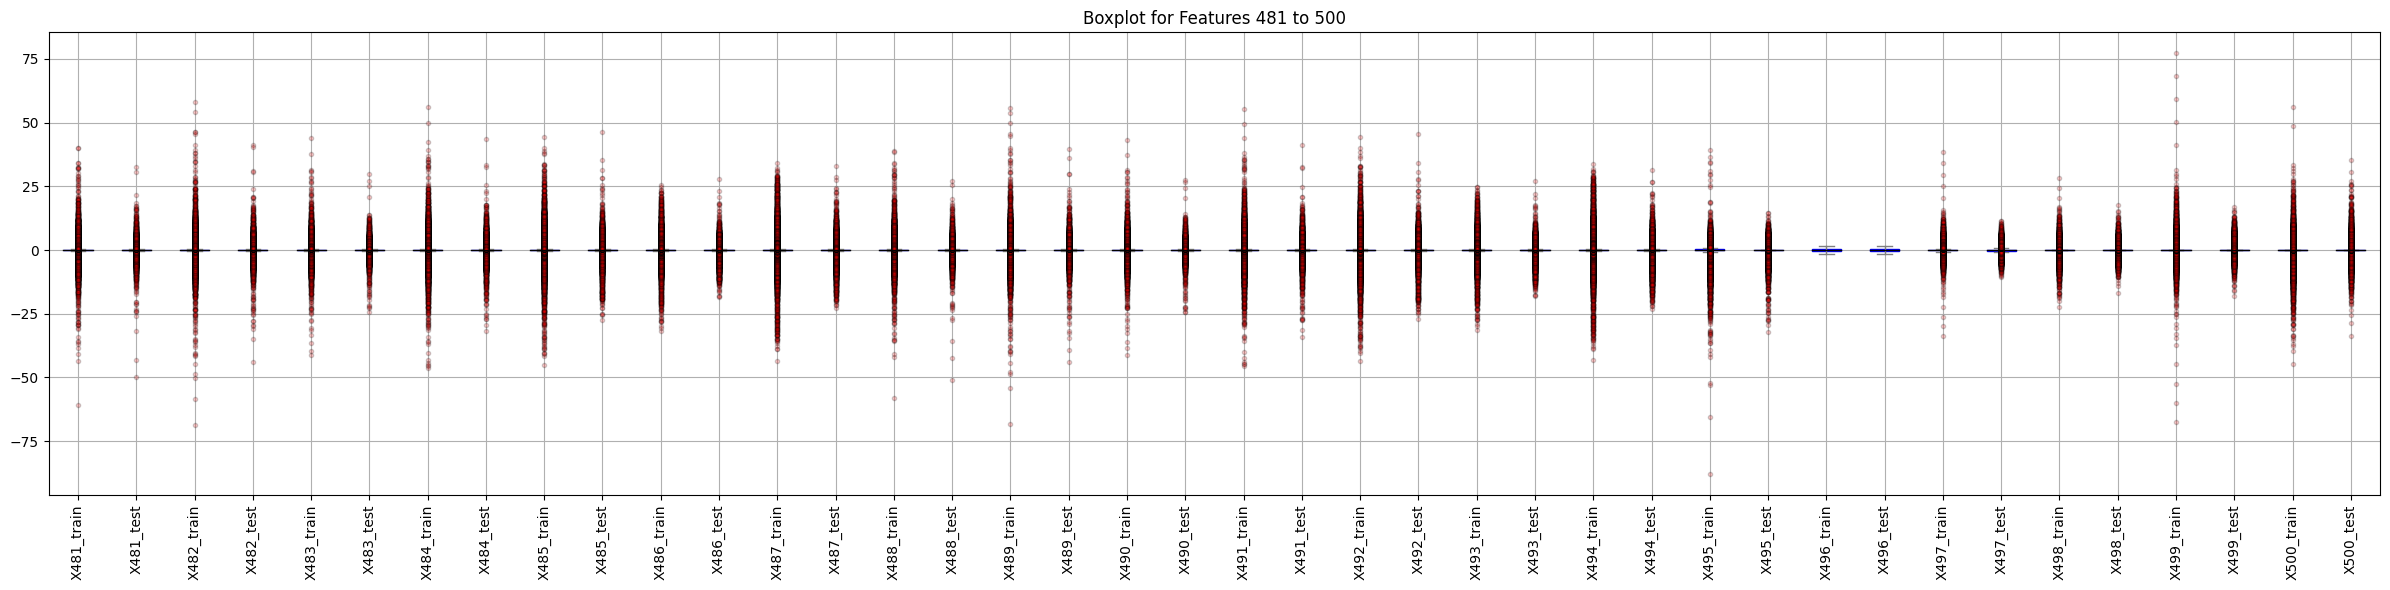

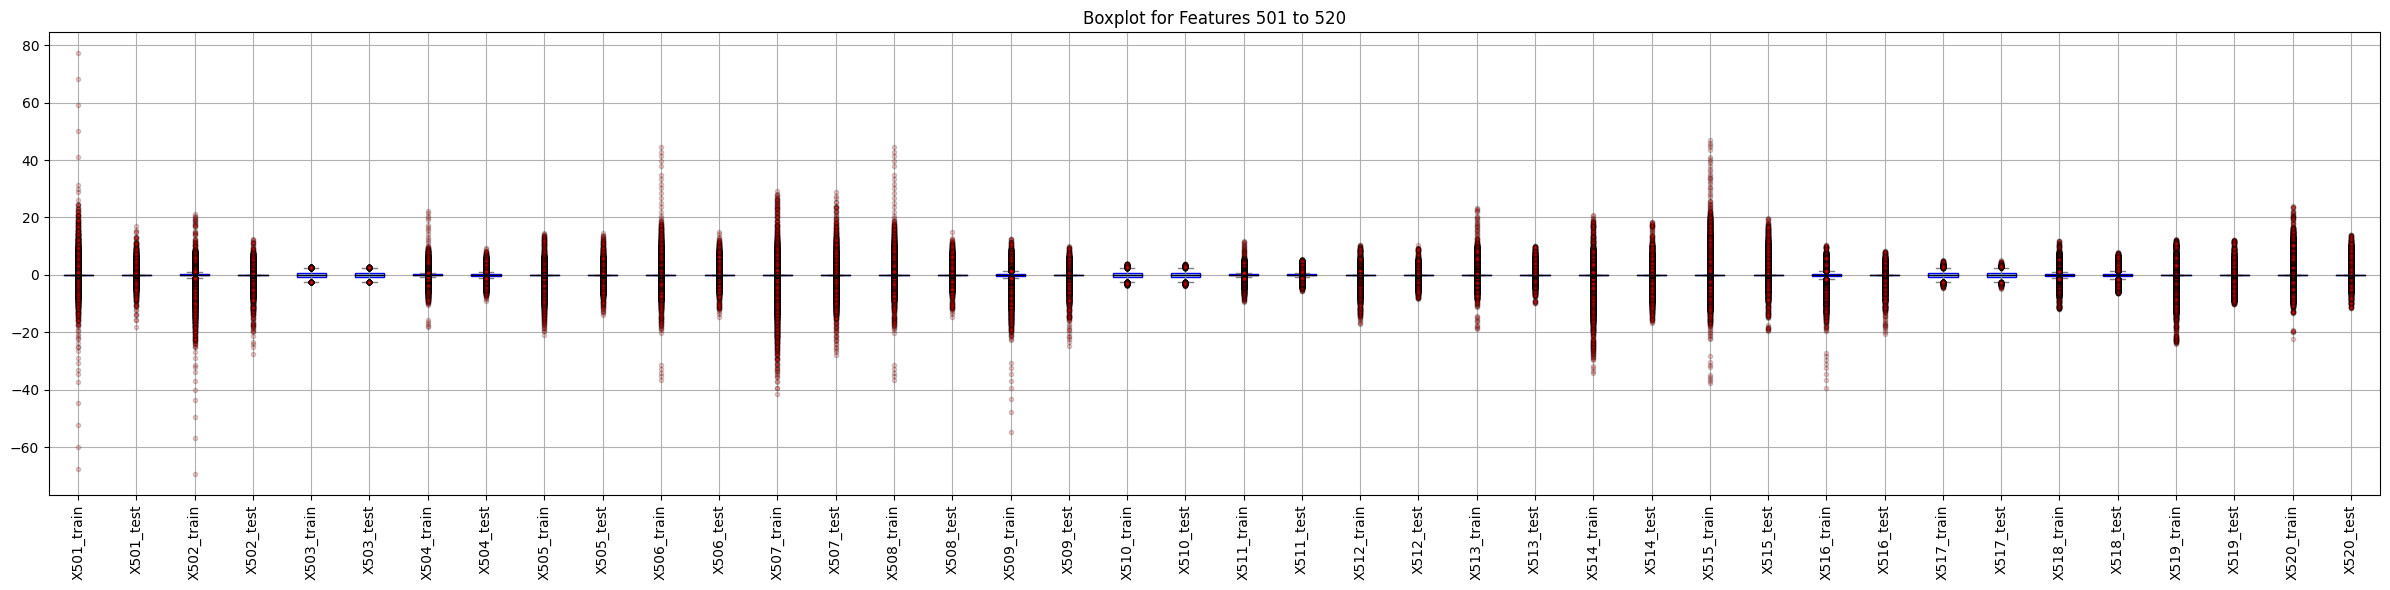

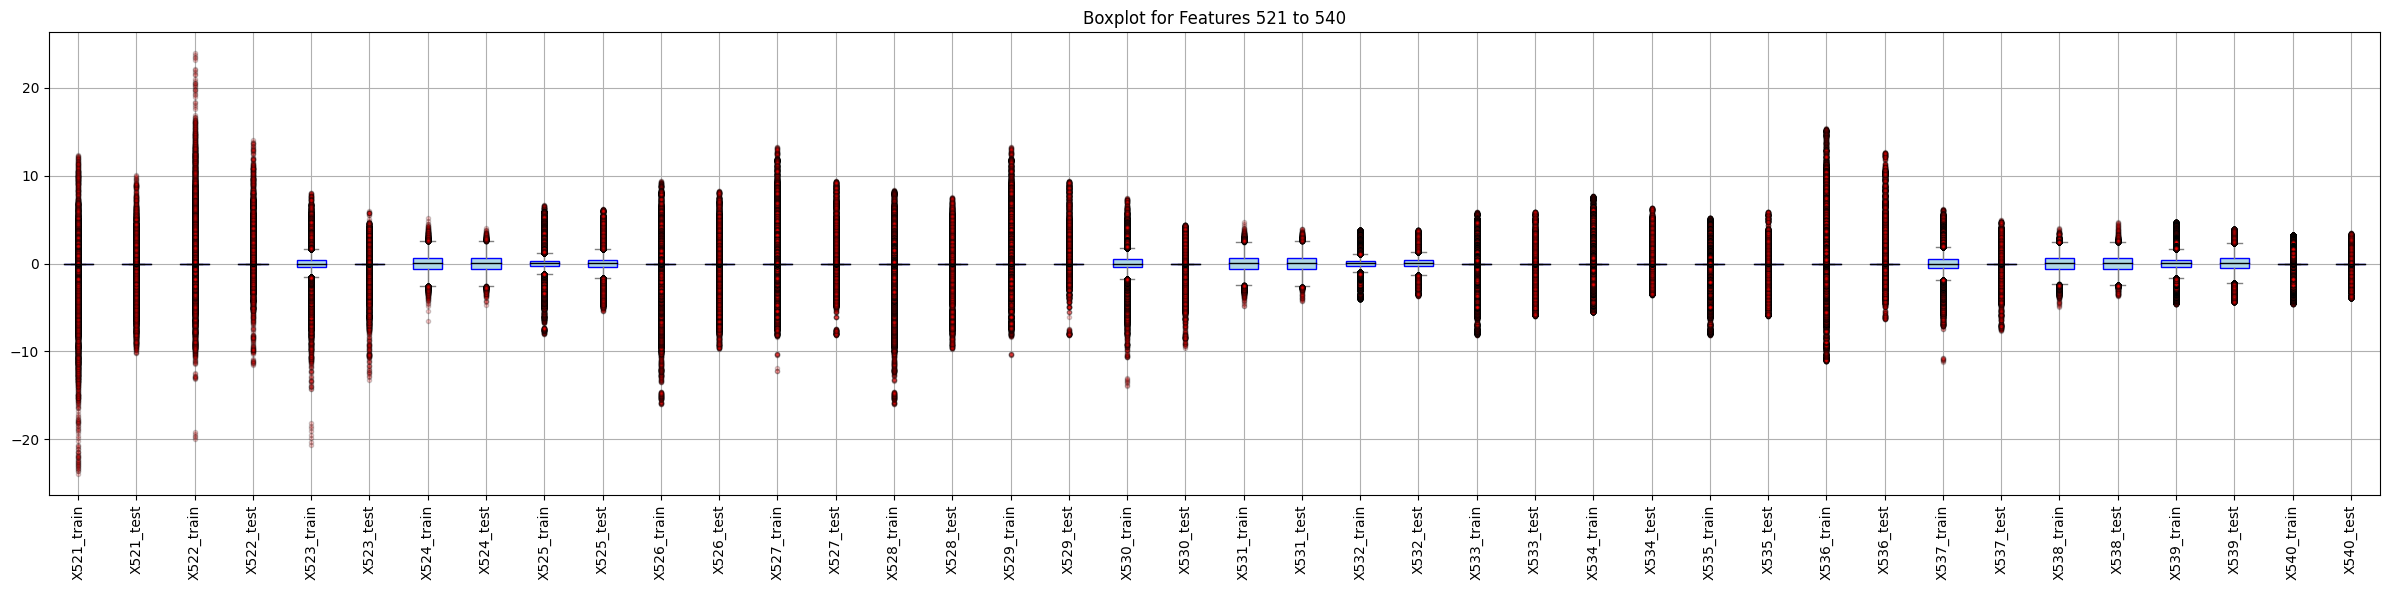

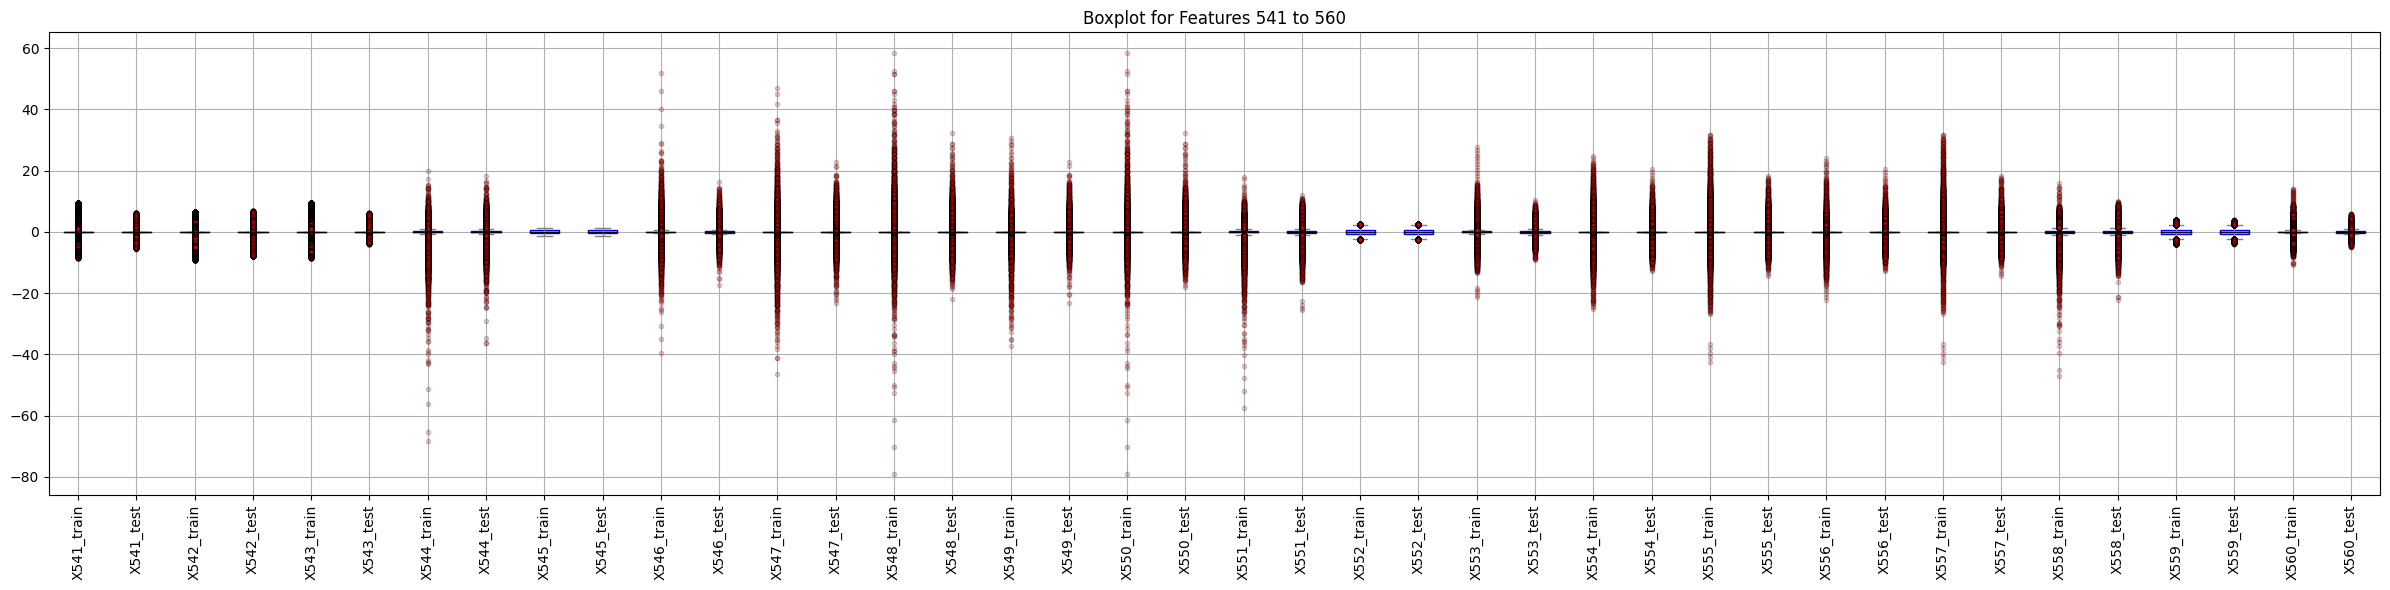

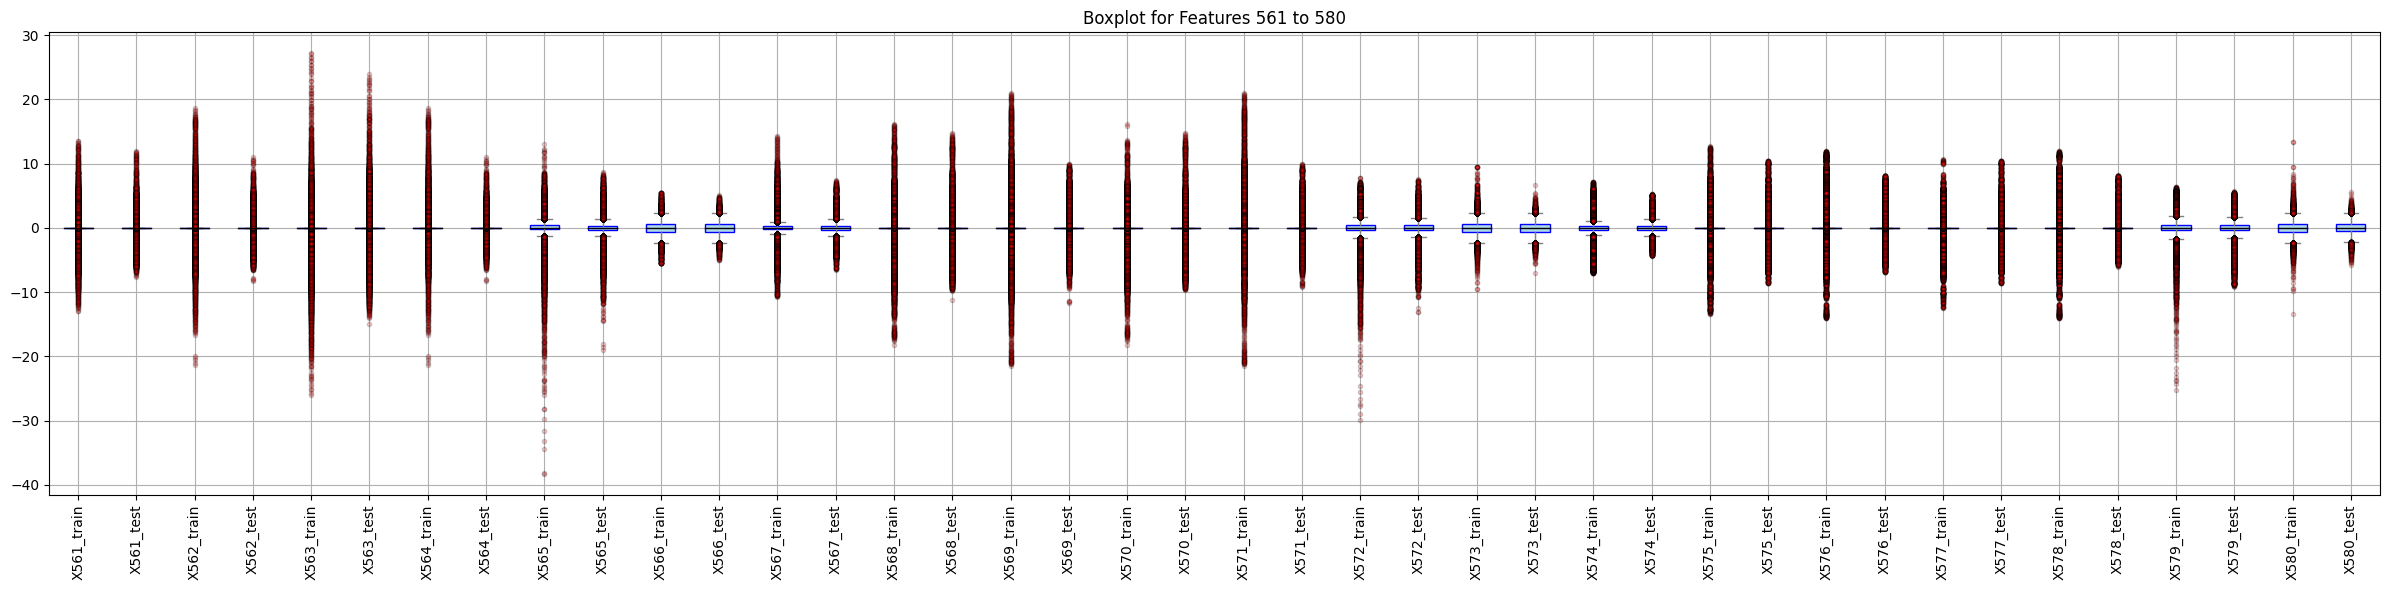

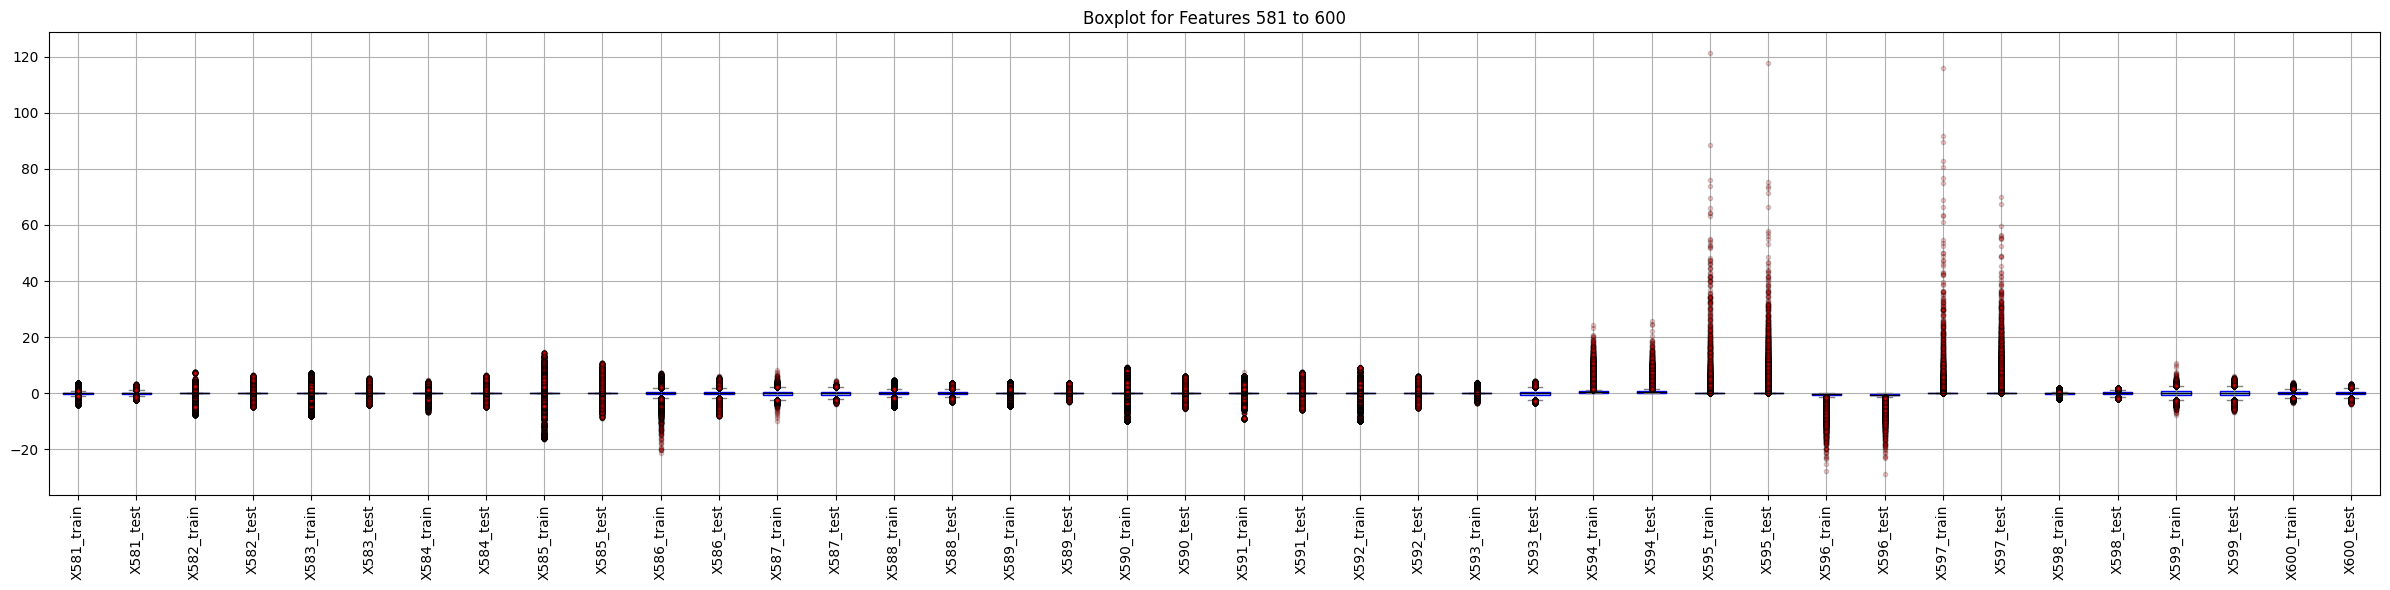

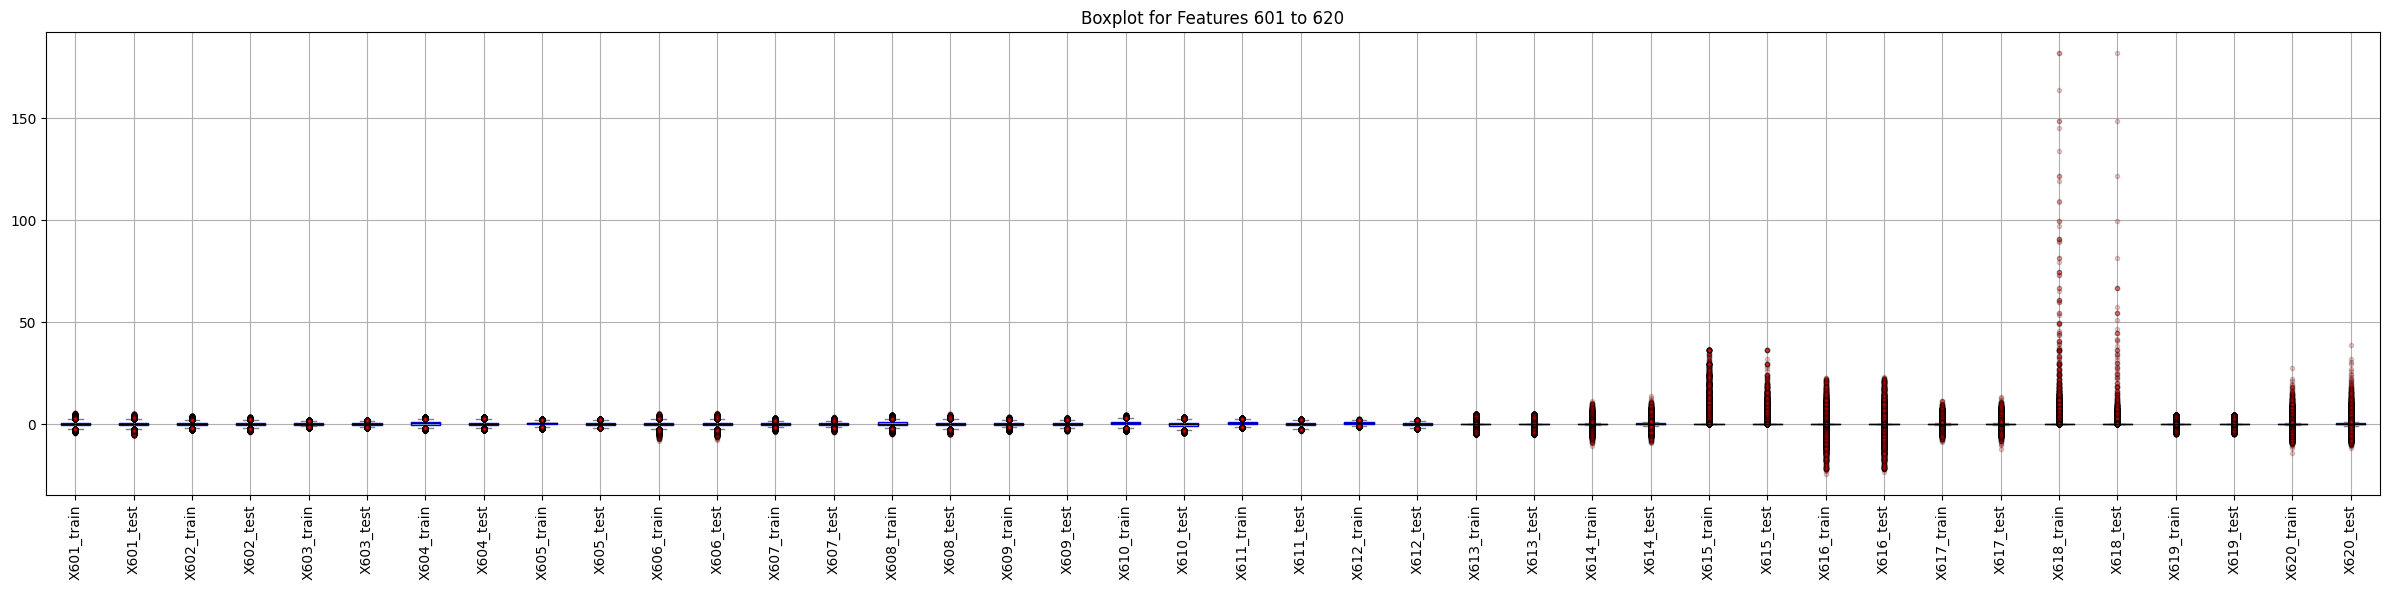

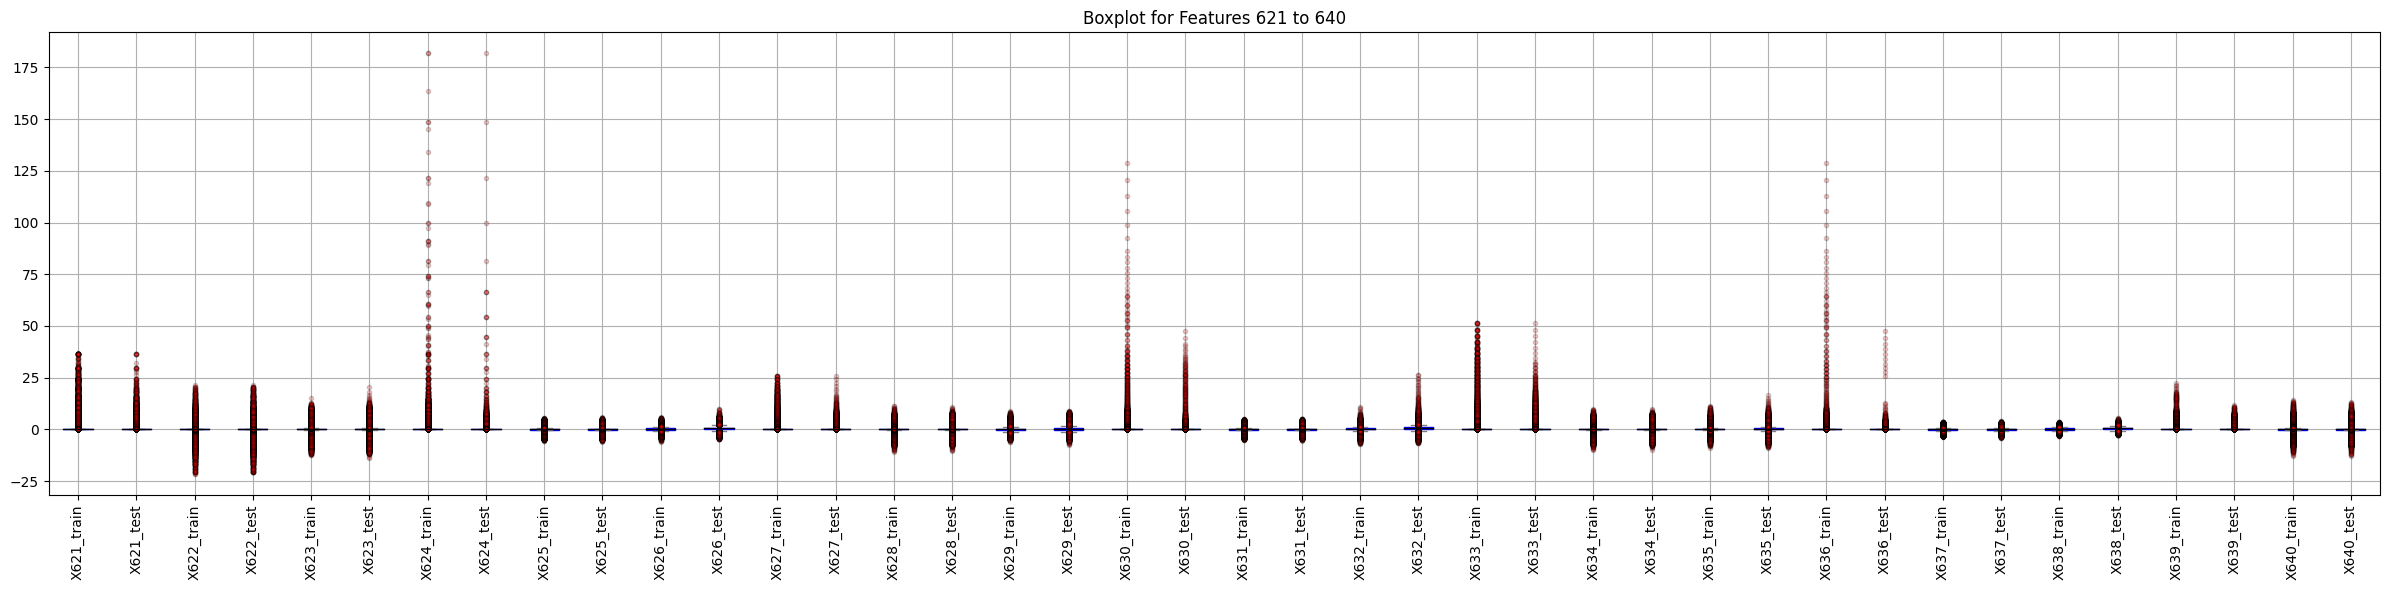

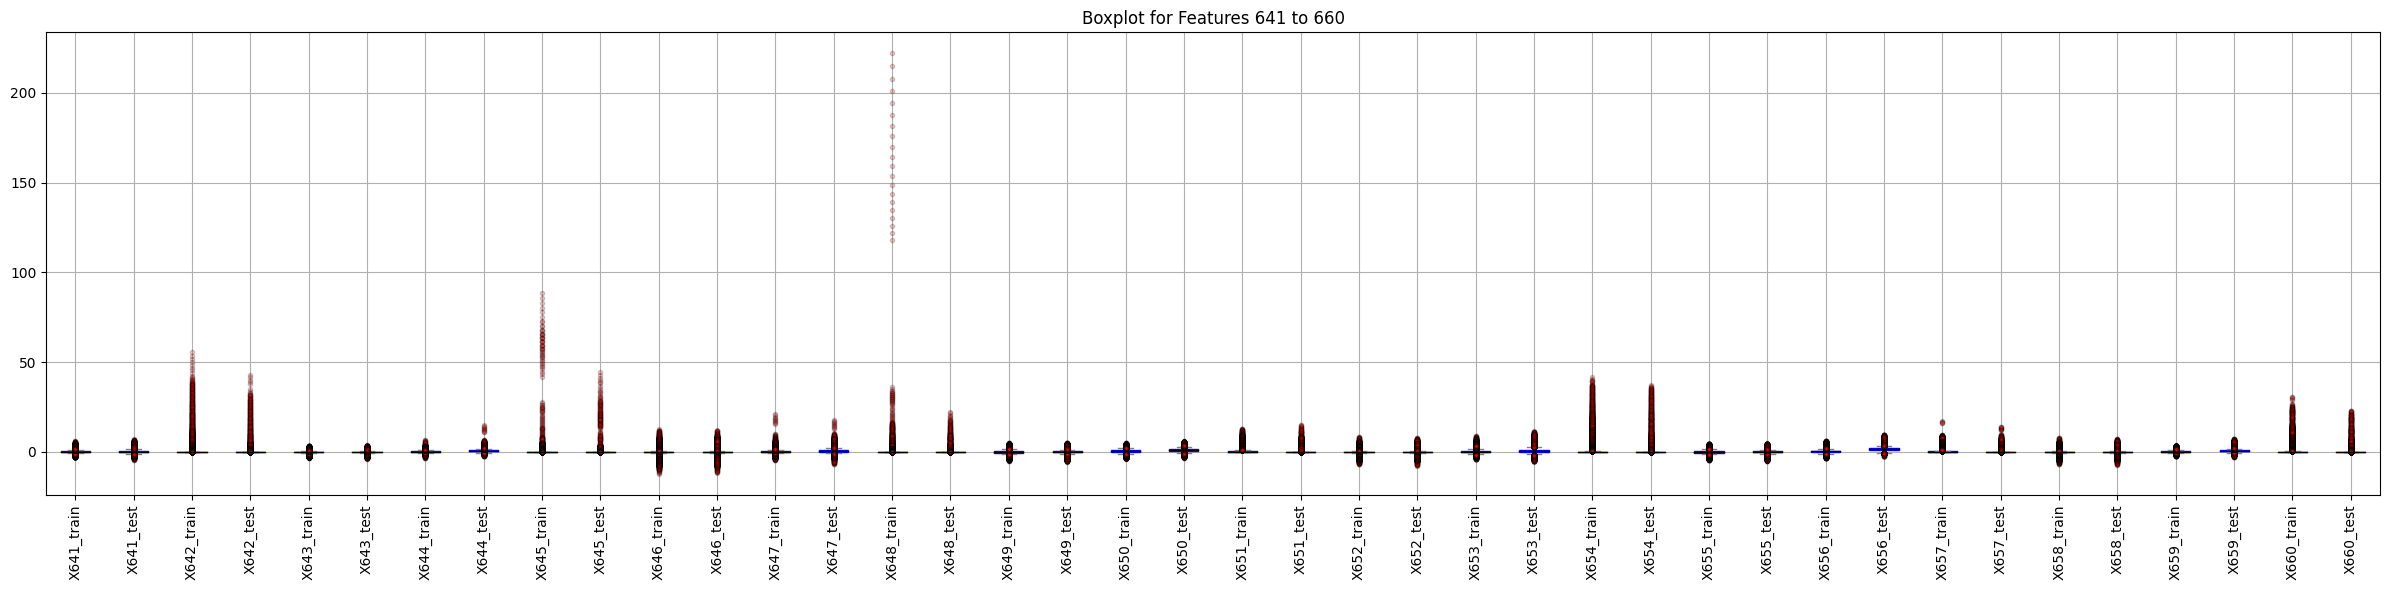

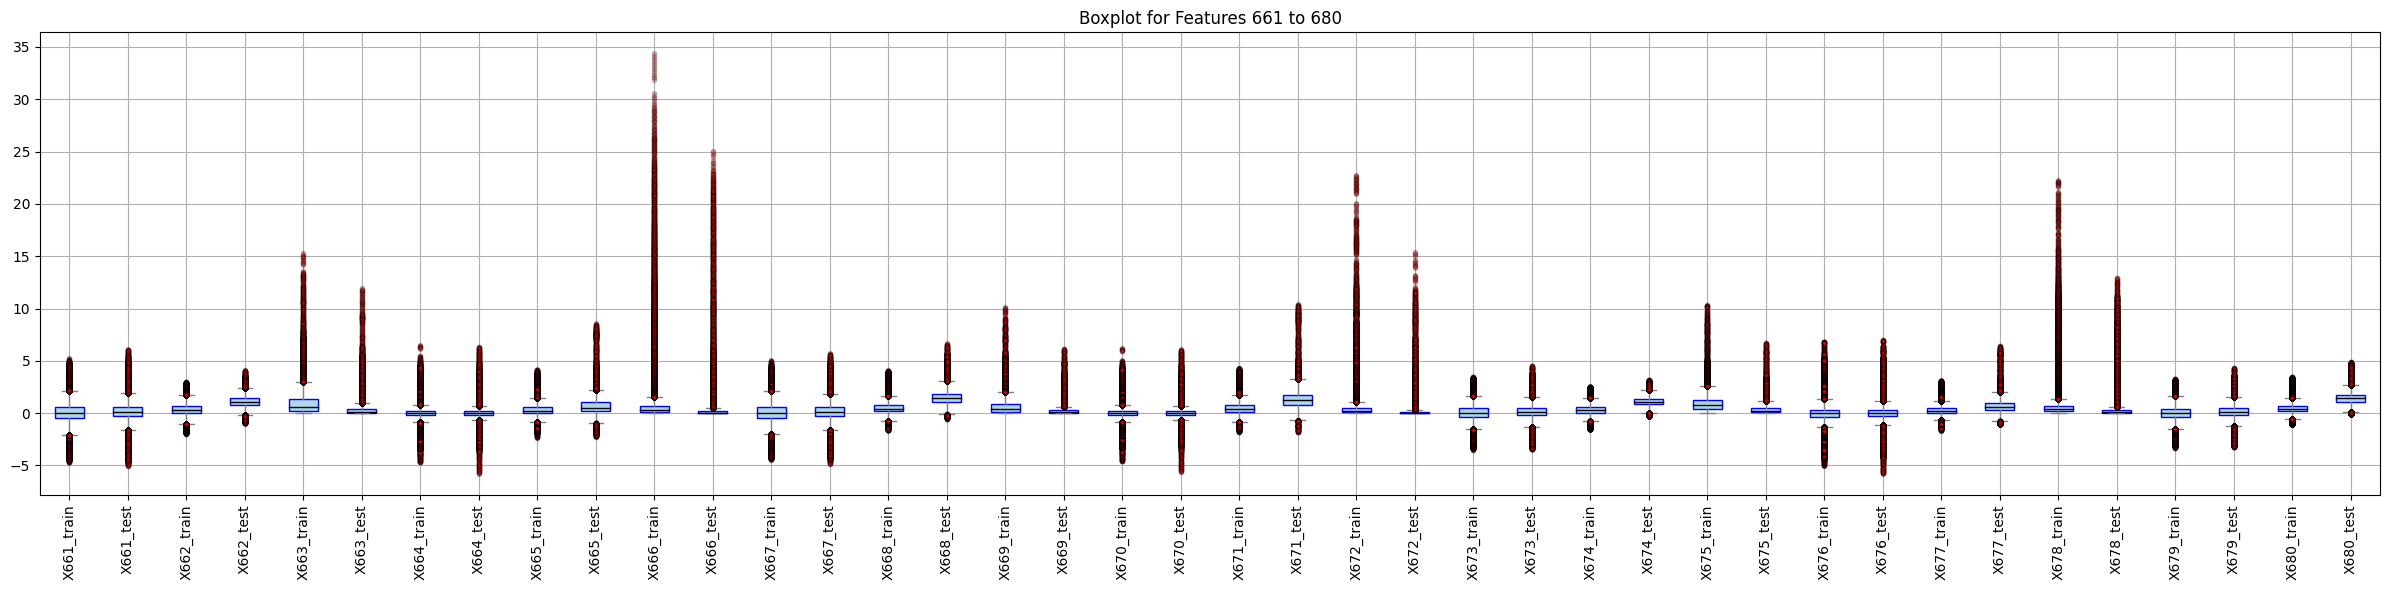

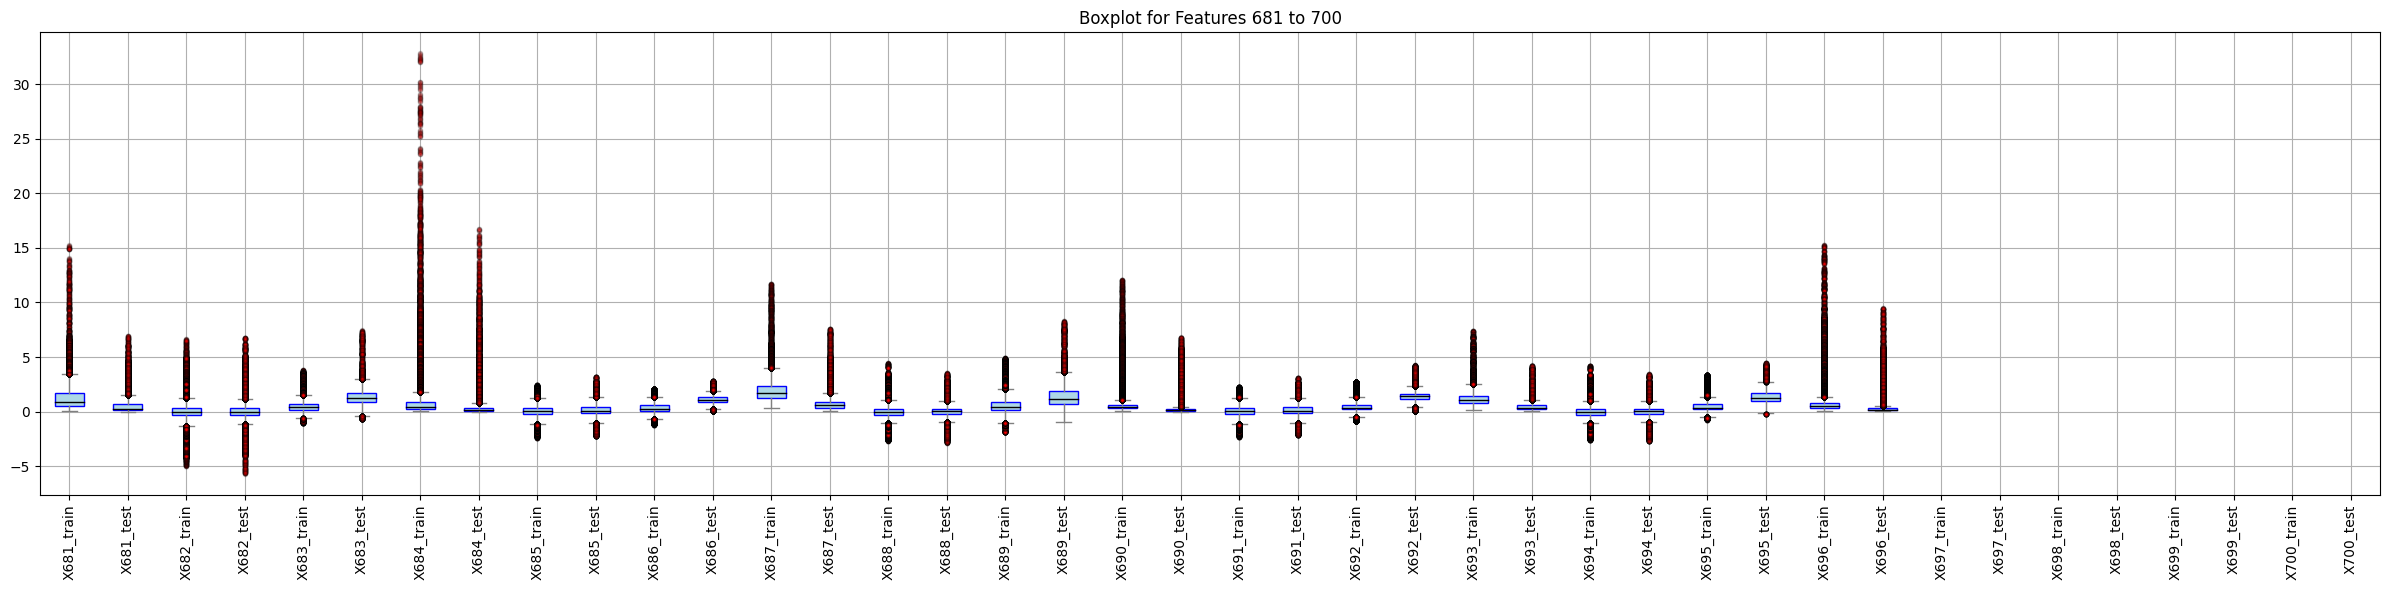

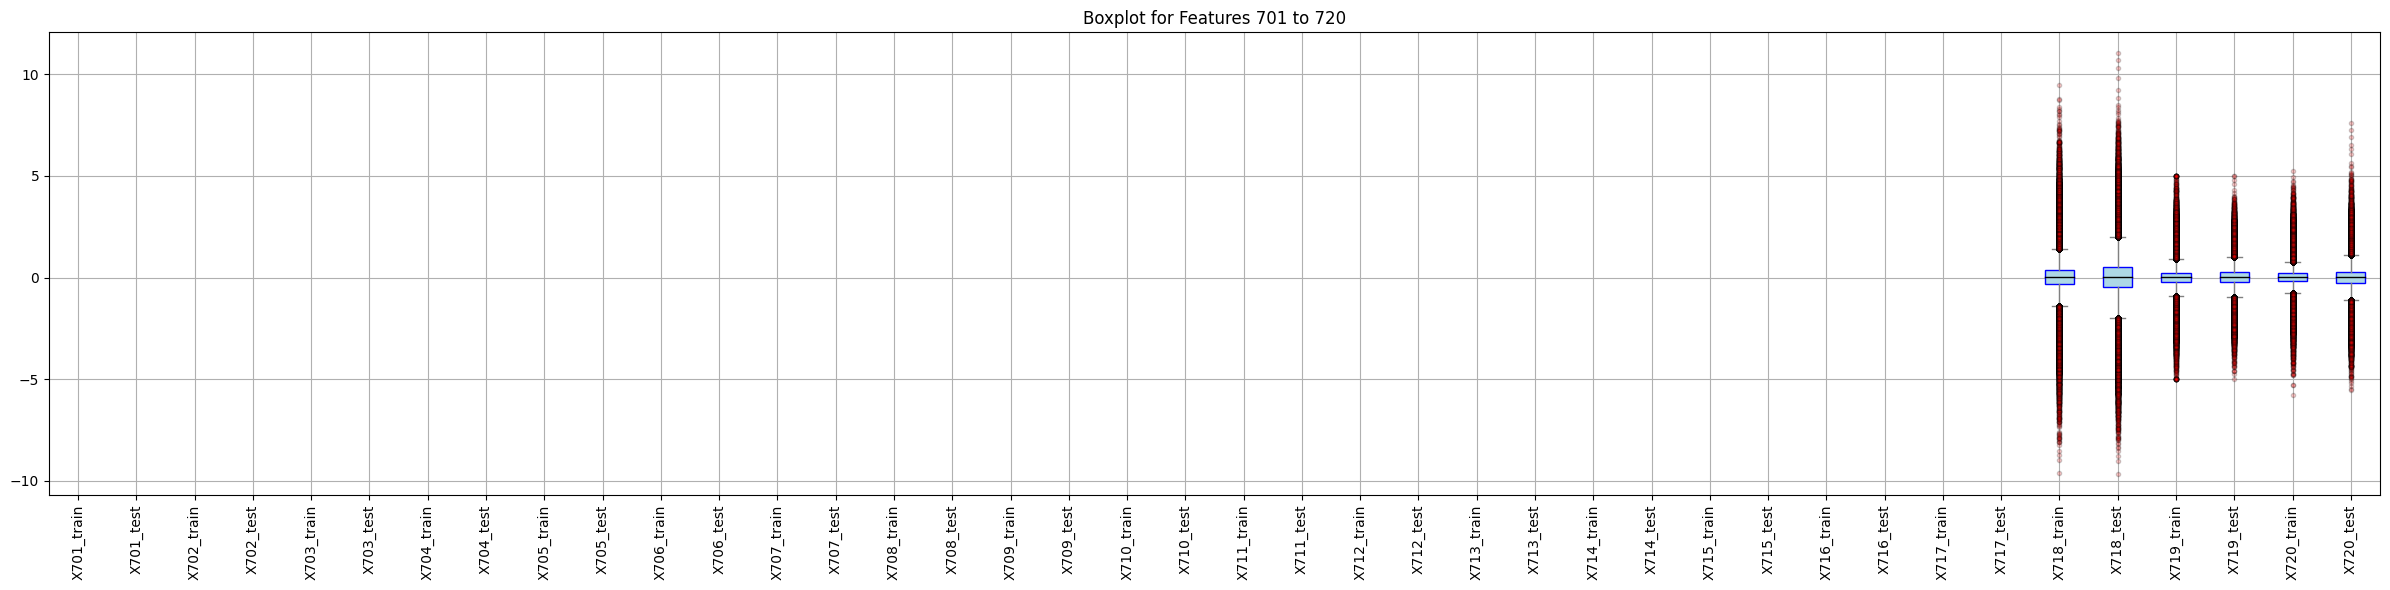

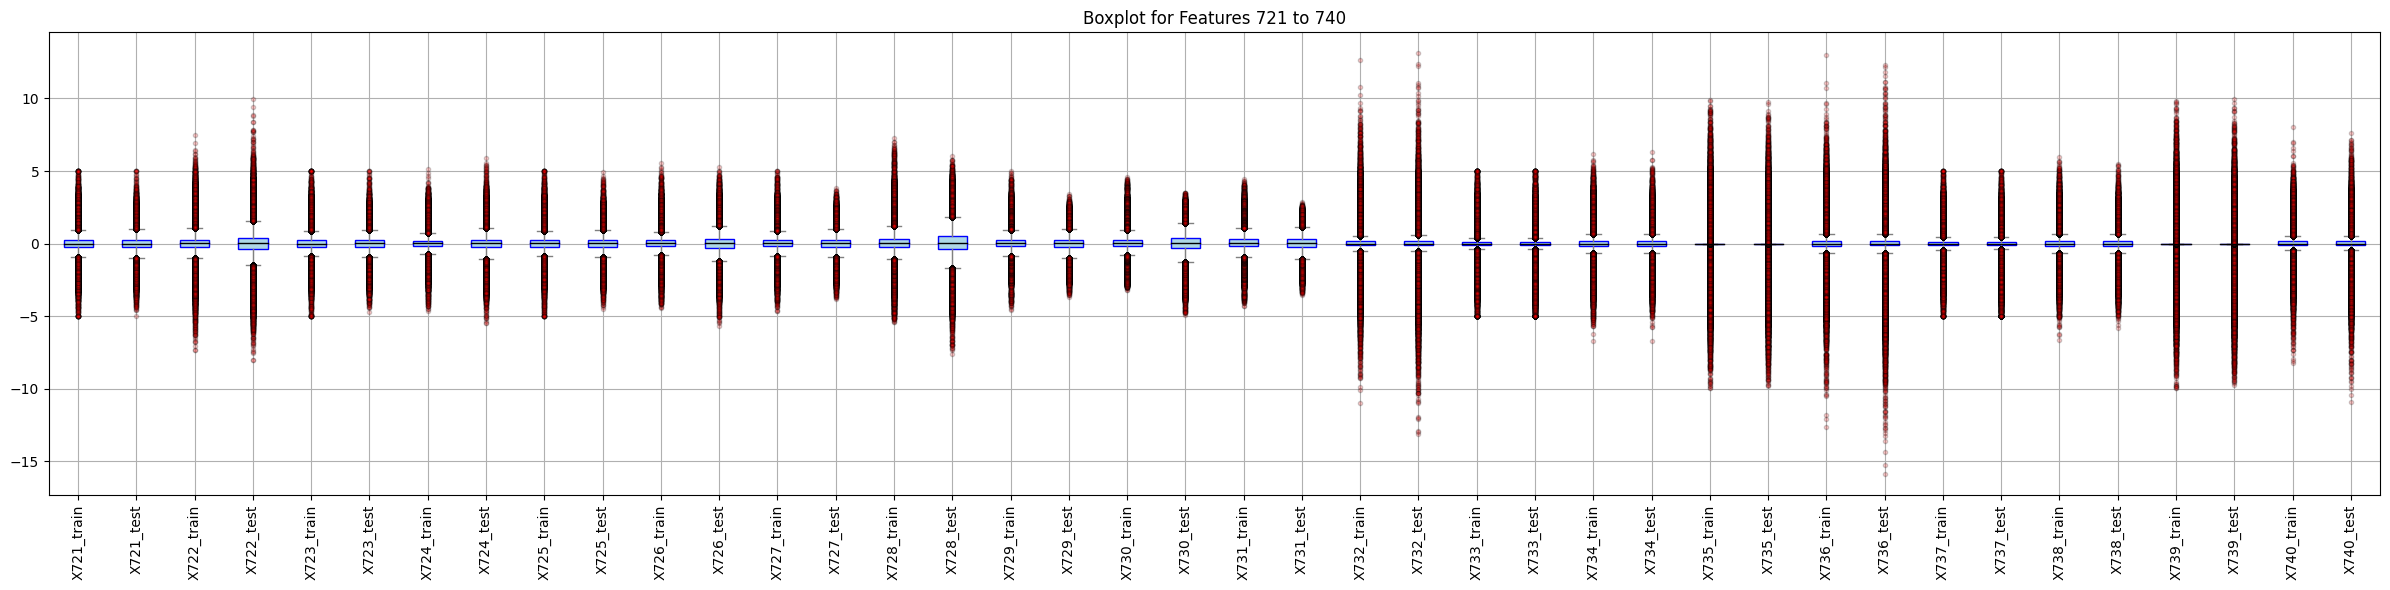

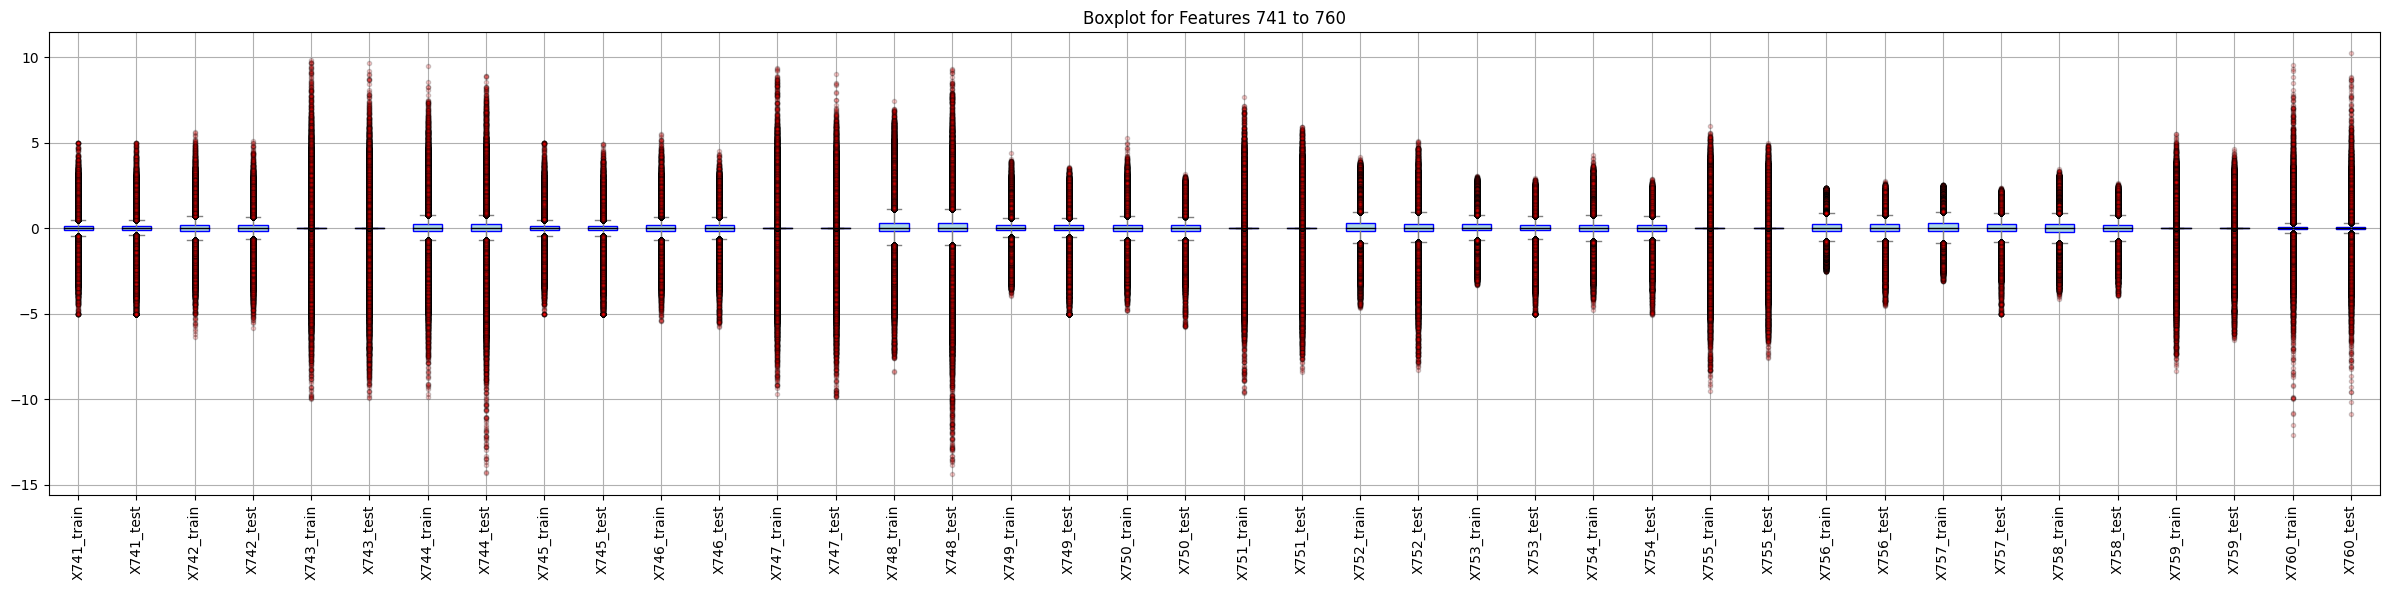

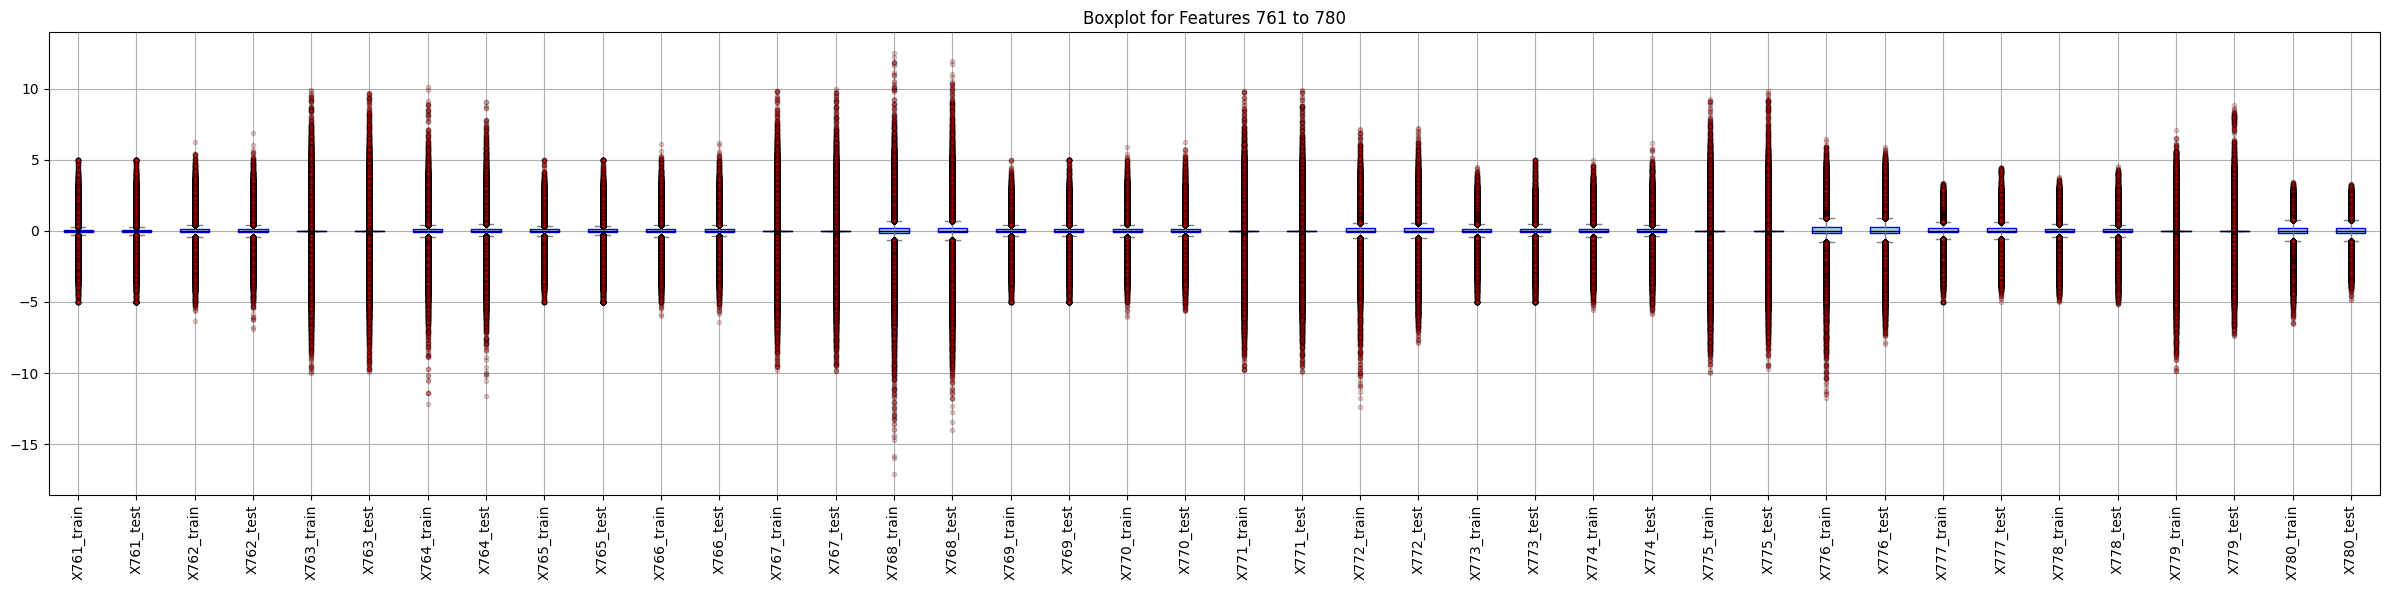

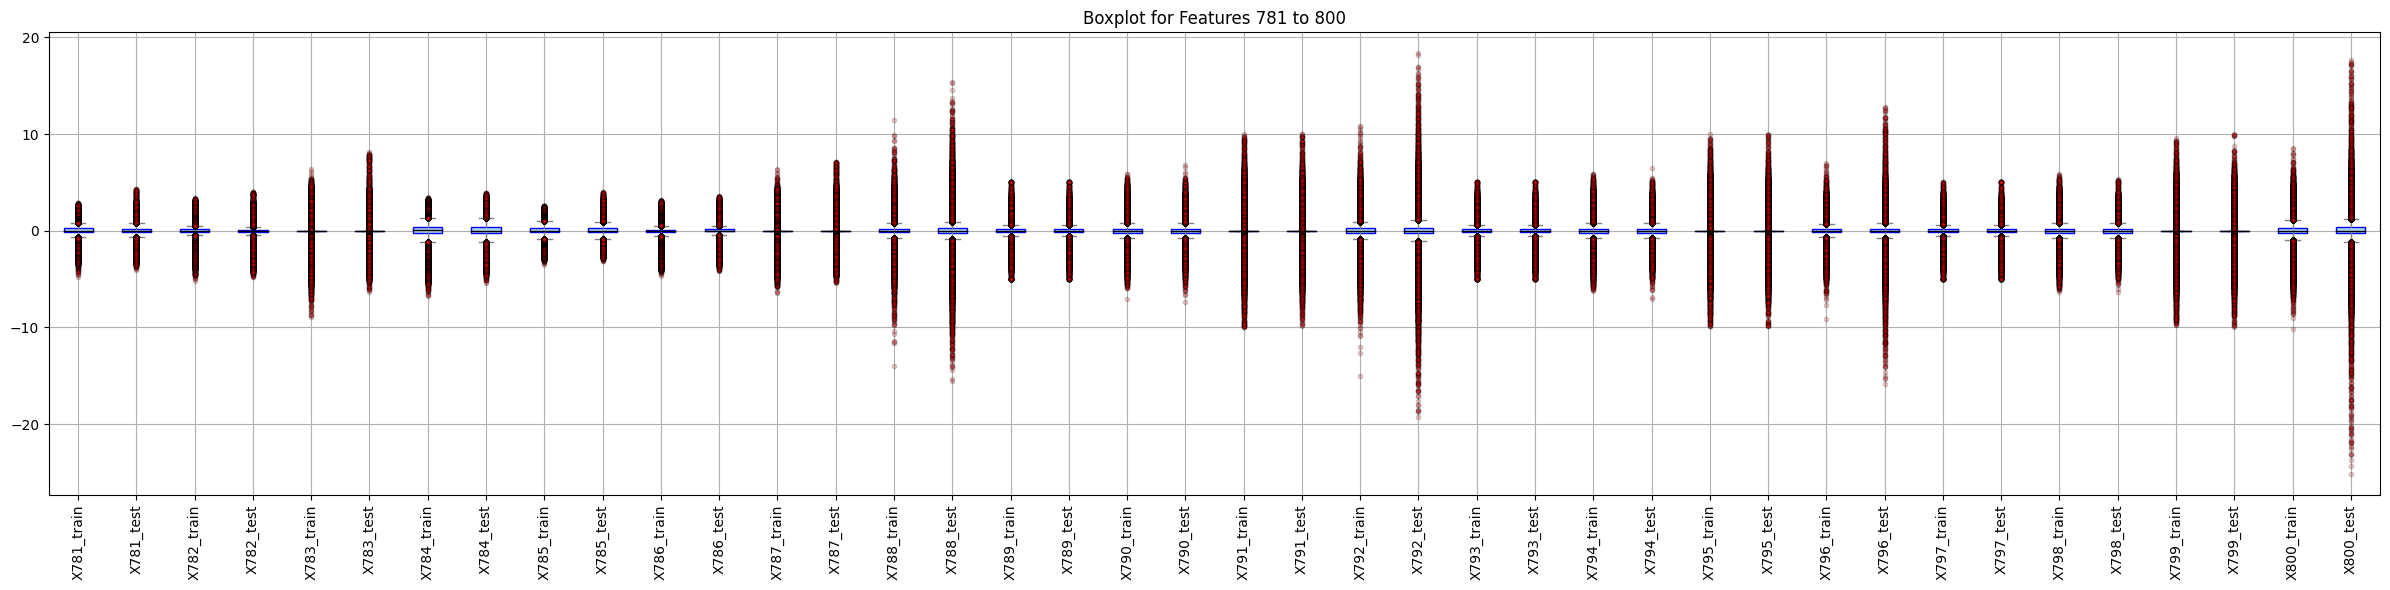

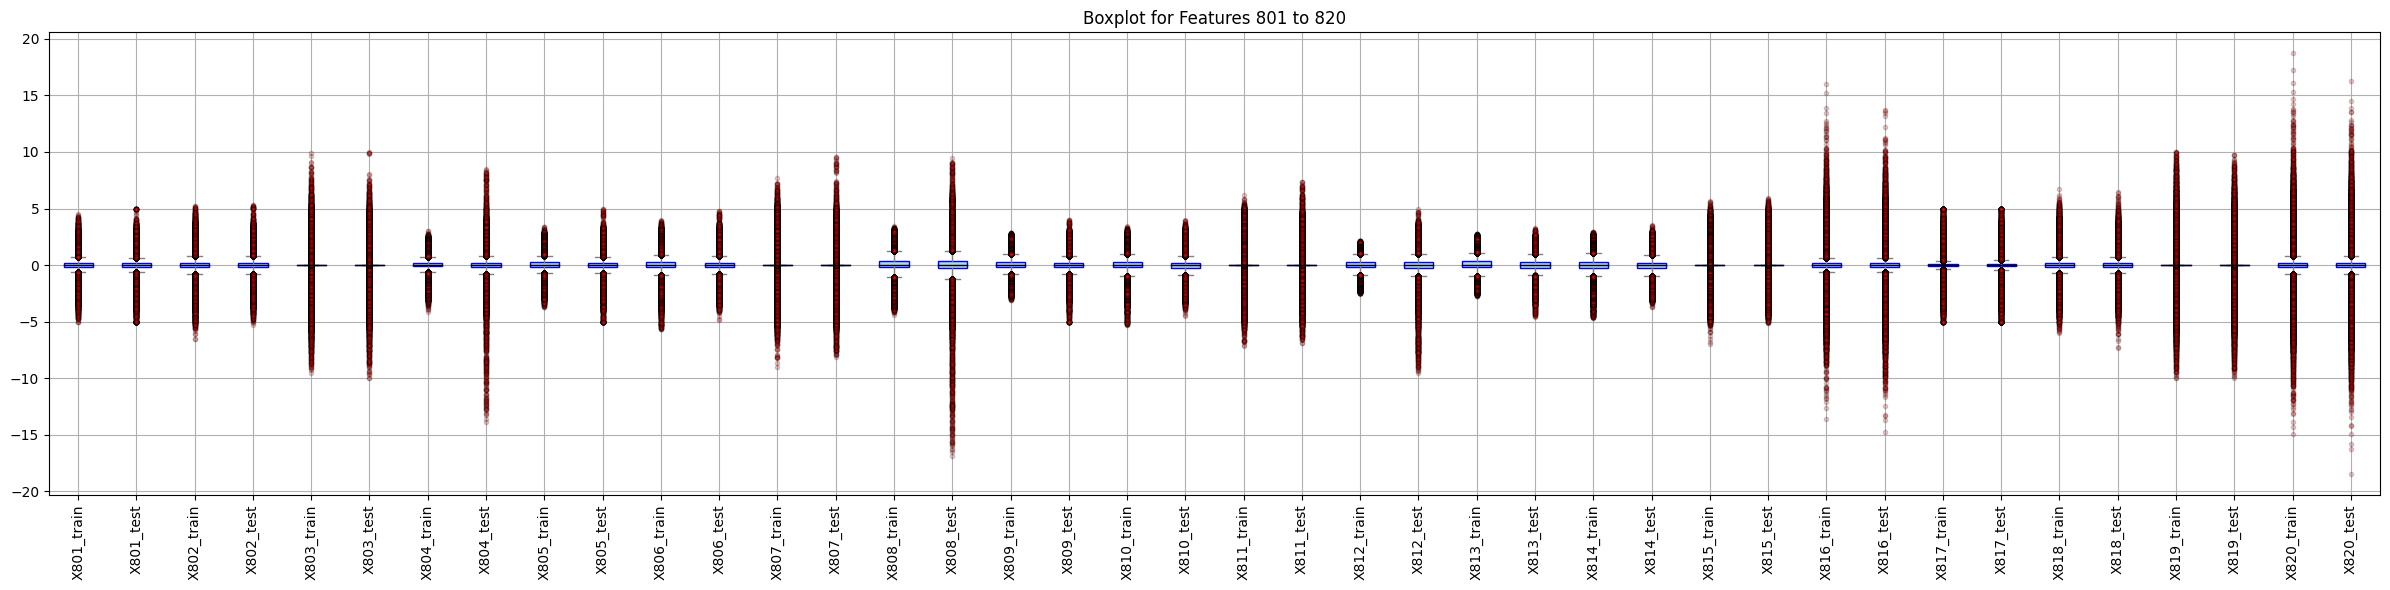

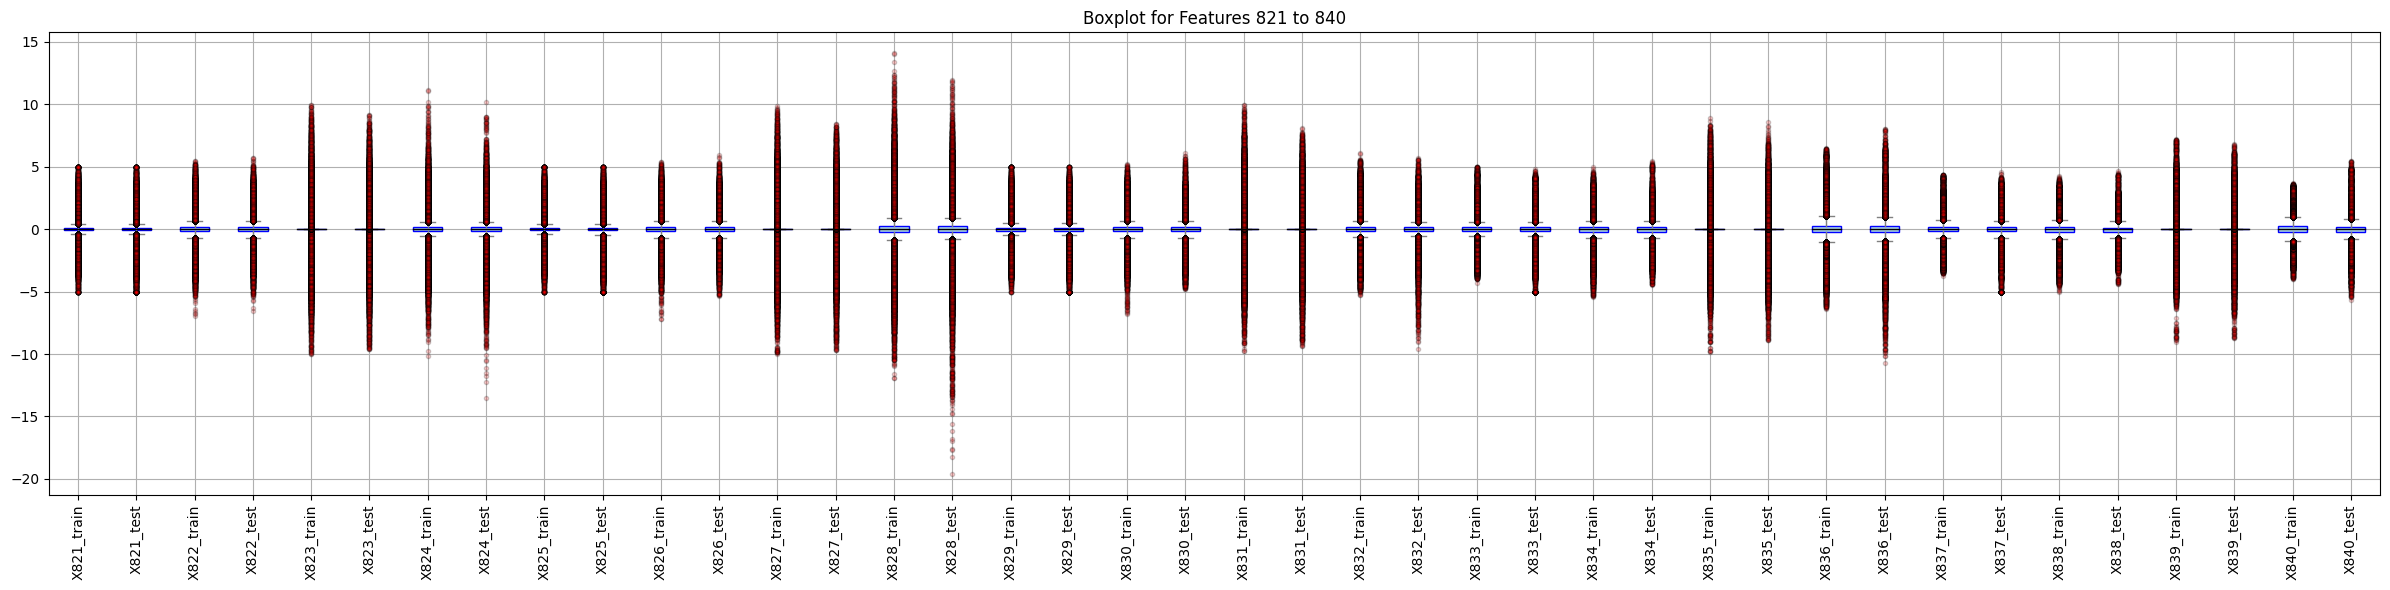

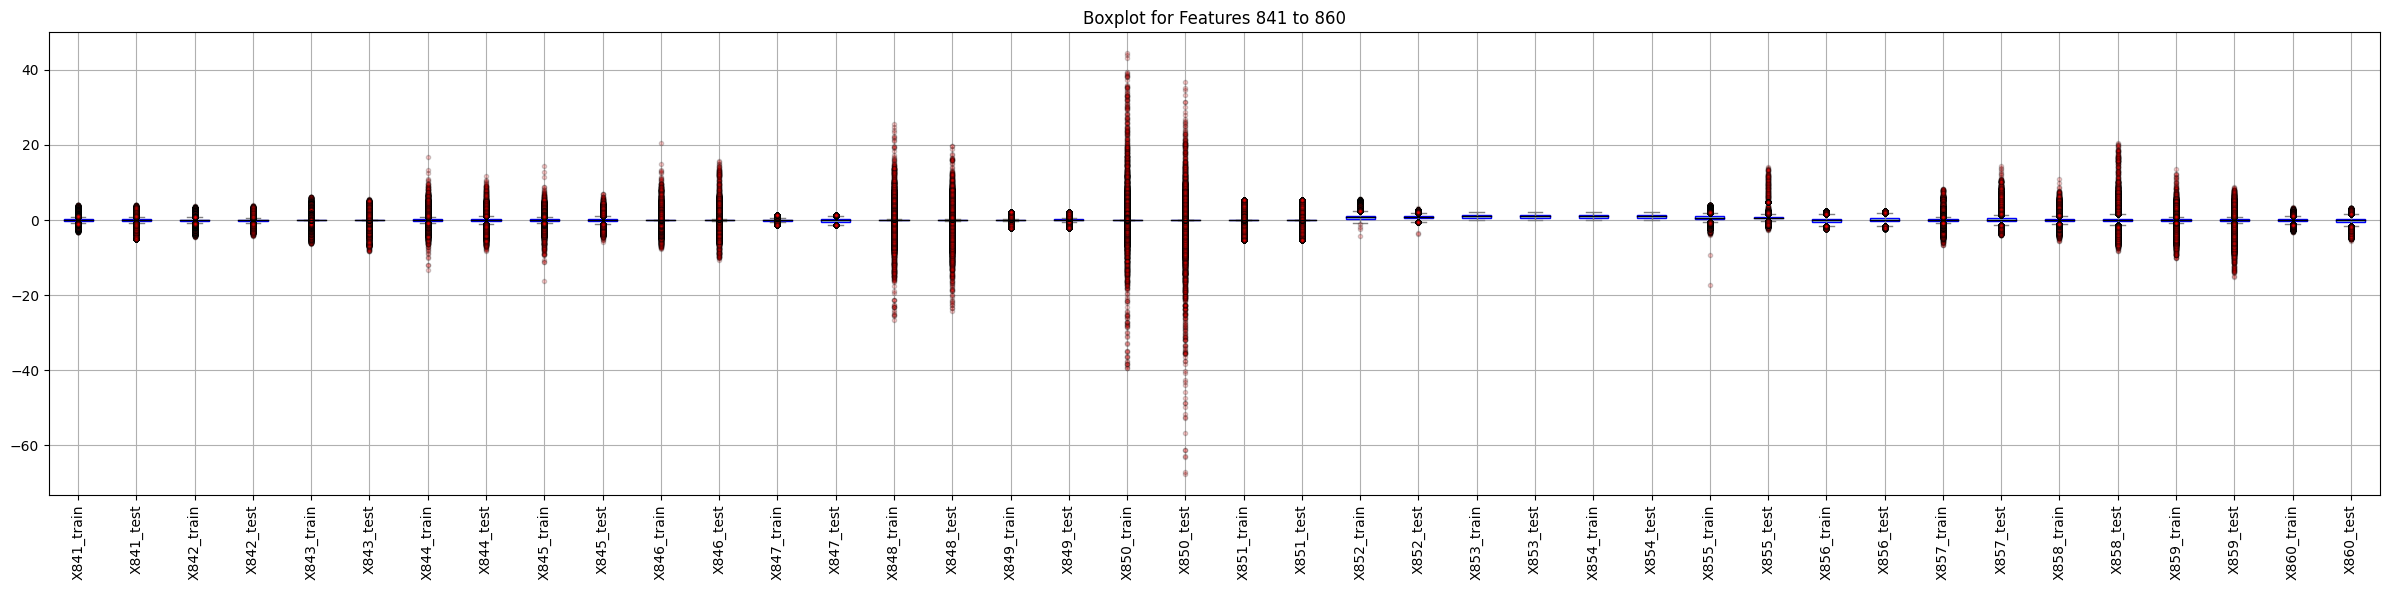

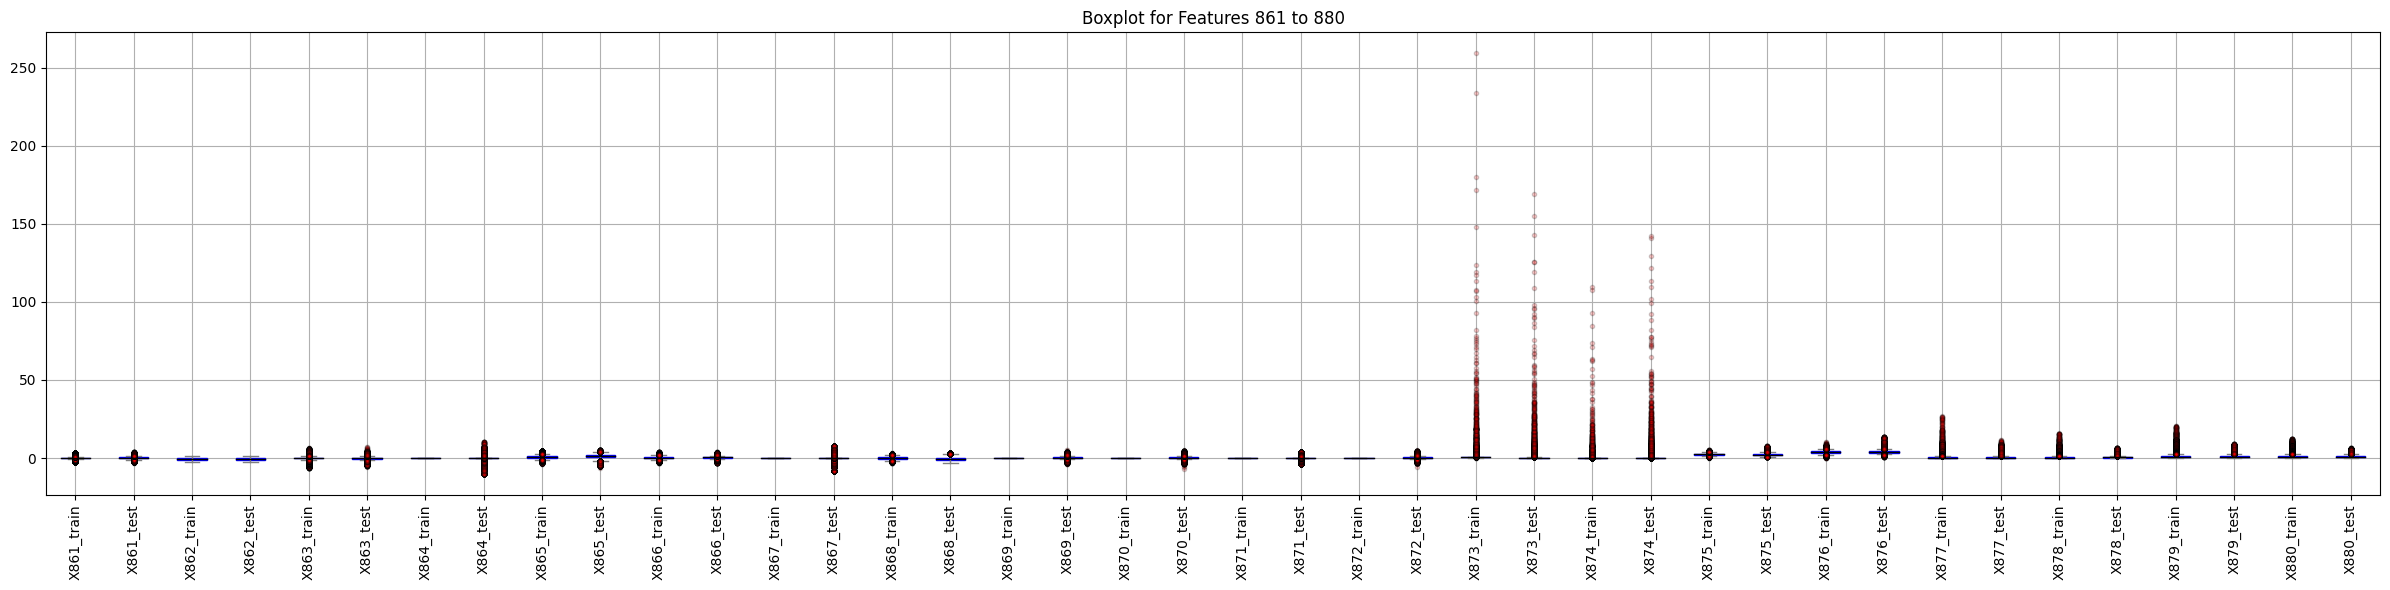

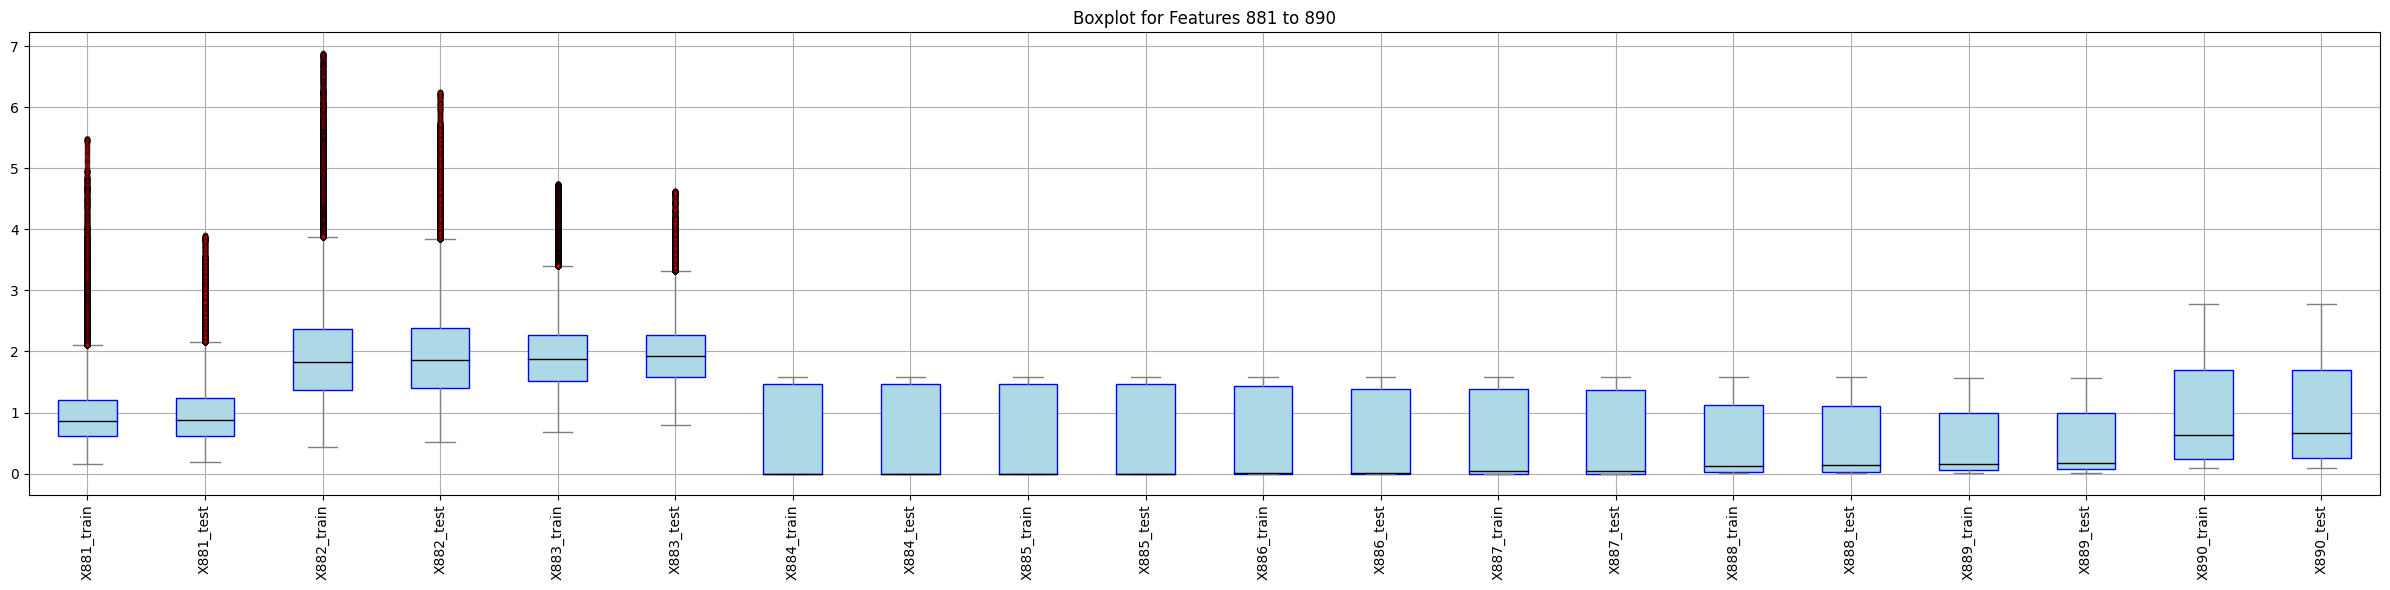

In [23]:
chunk_size = 20
for start in range(0, len(anonymized_features), chunk_size):
    end = min(start + chunk_size, len(anonymized_features))
    plot_cols = anonymized_features[start:end]
    
    ordered_cols = []
    for col in plot_cols:
        ordered_cols.append(f"{col}_train")
        ordered_cols.append(f"{col}_test")

    train_chunk = df_train[plot_cols].add_suffix('_train')
    test_chunk = df_test[plot_cols].add_suffix('_test')
    combined = pd.concat([train_chunk.replace([np.inf, -np.inf], np.nan),
                          test_chunk.replace([np.inf, -np.inf], np.nan)],
                         axis=1)
    
    plt.figure(figsize=(24, 6))
    box = combined.boxplot(
        column=ordered_cols,
        grid=True,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue', color='blue'),
        medianprops=dict(color='black'),
        whiskerprops=dict(color='gray'),
        capprops=dict(color='gray'),
        flierprops=dict(marker='o', markersize=3, linestyle='none', markerfacecolor='red', alpha=0.2)
    )

    plt.title(f'Boxplot for Features {start+1} to {end}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

## Constant Features

In [30]:
vc_train = {}
for col in anonymized_features:
    vc_train[col] = len(df_train[col].value_counts())

vc_test = {}
for col in anonymized_features:
    vc_test[col] = len(df_test[col].value_counts())

In [44]:
constant_df = pd.DataFrame({
    'feature': list(vc_train.keys()),  # or vc_test.keys(), since they're the same
    'constant_in_train': [v == 1 for v in vc_train.values()],
    'constant_in_test': [vc_test[k] == 1 for k in vc_train.keys()]
})
constant_in_train = [k for k, v in vc_train.items() if v == 1]
constant_df[constant_df['constant_in_train'] | constant_df['constant_in_test']]

feature  constant_in_train  constant_in_test
696    X697               True              True
697    X698               True              True
698    X699               True              True
699    X700               True              True
700    X701               True              True
701    X702               True              True
702    X703               True              True
703    X704               True              True
704    X705               True              True
705    X706               True              True
706    X707               True              True
707    X708               True              True
708    X709               True              True
709    X710               True              True
710    X711               True              True
711    X712               True              True
712    X713               True              True
713    X714               True              True
714    X715               True              True
715    X716               True              True
716    X717               True              True
863    X864               True             False
866    X867               True             False
868    X869               True             False
869    X870               True             False
870    X871               True             False
871    X872               True             False

## Pairwise Correlation

In [45]:
corr_train = df_train[anonymized_features].corr(method='pearson')
corr_train.to_parquet('corr_matrix_train.parquet', index=True)

In [73]:
corr_train_long = corr_train.stack().reset_index()
corr_train_long.columns = ['x', 'y', 'corr']

corr_train_long = corr_train_long[
    (corr_train_long['x'] != corr_train_long['y']) &
    (~corr_train_long['x'].isin(constant_in_train)) &
    (~corr_train_long['y'].isin(constant_in_train))
]


corr_train_long['x_min'] = corr_train_long[['x', 'y']].min(axis=1)
corr_train_long['x_max'] = corr_train_long[['x', 'y']].max(axis=1)

corr_train_long = corr_train_long.drop_duplicates(subset=['x_min', 'x_max'])

corr_train_long['x'] = corr_train_long['x_min']
corr_train_long['y'] = corr_train_long['x_max']
corr_train_long = corr_train_long.drop(columns=['x_min', 'x_max'])

In [105]:
corr_train_1 = corr_train_long[corr_train_long['corr'] == 1].sort_values(by = ['x'])
corr_train_1['corr_test'] = corr_train_1.apply(lambda x: df_test[x.x].corr(df_test[x.y], method='pearson'), axis = 1)

In [88]:
set_x = set(corr_train_long[corr_train_long['corr'] == 1].x)
set_y = set(corr_train_long[corr_train_long['corr'] == 1].y)

In [106]:
corr_train_1

x     y  corr  corr_test
52746   X104   X62   1.0        1.0
89034   X104  X146   1.0        1.0
57930   X110   X68   1.0        1.0
94218   X110  X152   1.0        1.0
63114   X116   X74   1.0        1.0
99402   X116  X158   1.0        1.0
104586  X122  X164   1.0        1.0
68298   X122   X80   1.0        1.0
109770  X128  X170   1.0        1.0
73482   X128   X86   1.0        1.0
114954  X134  X176   1.0        1.0
78666   X134   X92   1.0        1.0
120138  X140  X182   1.0        1.0
83850   X140   X98   1.0        1.0
52788   X146   X62   1.0        1.0
57972   X152   X68   1.0        1.0
63156   X158   X74   1.0        1.0
68340   X164   X80   1.0        1.0
73524   X170   X86   1.0        1.0
78708   X176   X92   1.0        1.0
83892   X182   X98   1.0        1.0
266154  X309  X351   1.0        1.0
266196  X309  X393   1.0        1.0
271338  X315  X357   1.0        1.0
271380  X315  X399   1.0        1.0
276522  X321  X363   1.0        1.0
276564  X321  X405   1.0        1.0
281748  X327  X411   1.0        1.0
281706  X327  X369   1.0        1.0
286890  X333  X375   1.0        1.0
286932  X333  X417   1.0        1.0
292074  X339  X381   1.0        1.0
292116  X339  X423   1.0        1.0
297258  X345  X387   1.0        1.0
297300  X345  X429   1.0        1.0
302442  X351  X393   1.0        1.0
307626  X357  X399   1.0        1.0
312810  X363  X405   1.0        1.0
317994  X369  X411   1.0        1.0
323178  X375  X417   1.0        1.0
328362  X381  X423   1.0        1.0
333546  X387  X429   1.0        1.0

In [108]:
corr_columns_to_drop = list(set(corr_train_long[corr_train_long['corr'] == 1].y))

## Covariate Drift

In [113]:
from scipy.stats import ks_2samp

In [124]:
drift_scores = {}

for col in anonymized_features:
    ks = ks_2samp(df_train[col], df_test[col])
    drift_scores[col] = ks.statistic * ks.statistic_sign

drift_scores = dict(sorted(drift_scores.items(), key=lambda item: -abs(item[1])))

In [135]:
list(drift_scores.items())[:10]

[('X873', -0.9837053688156325),
 ('X692', 0.7493170879427055),
 ('X680', 0.7171761221510015),
 ('X686', 0.707336430215935),
 ('X695', 0.6847131235849994),
 ('X687', -0.6744364204378591),
 ('X668', 0.6718170376482929),
 ('X690', -0.6656626694301155),
 ('X693', -0.6438515433489752),
 ('X674', 0.6419962827510054)]

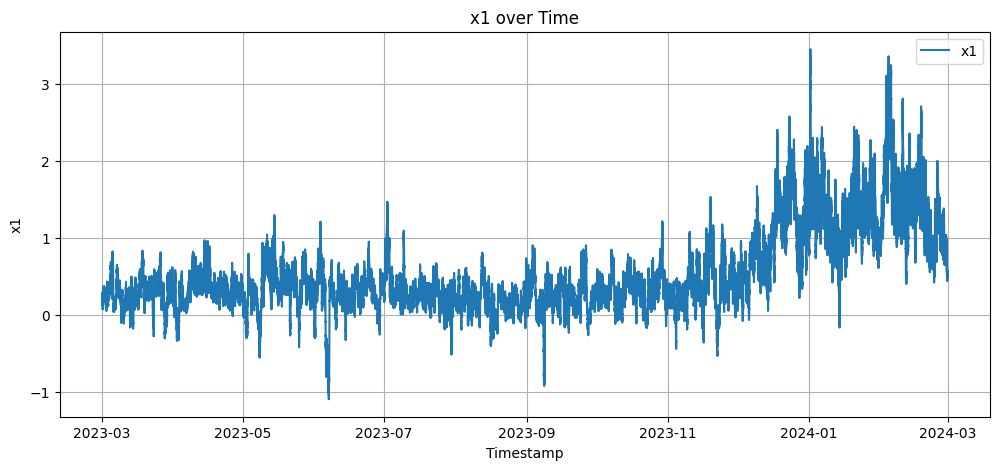

In [143]:
plt.figure(figsize=(12, 5))
plt.plot(df_train.index, df_train['X680'], label='x1')
plt.title("x1 over Time")
plt.xlabel("Timestamp")
plt.ylabel("x1")
plt.grid(True)
plt.legend()
plt.show()

In [144]:
df_train['X680'].autocorr(lag=1) ## High ks High Autocorrelation

0.9997188913317344

In [145]:
df_train['X873'].autocorr(lag=1) ## High ks low Autocorrelation

0.13882513733070578